# 1. Fitting Ne lines in a loop
- This is the first step of fitting Diad data
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)
- Uncomment this line if you havent installed DiadFit, or are running a much older version. 

In [12]:
#!pip install --upgrade DiadFit

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
# This needs to be 0.0.68 or higher!
pf.__version__

'0.0.77'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [14]:
import os
DayFolder=os.getcwd()
meta_path=DayFolder +  '\MetaData'
spectra_path=DayFolder + '\Spectra'
filetype='headless_txt'
# What is your file extension? .txt, .csv, .xlsx?
file_ext='.txt'
# Does your file start with a prefix? E.g 01 Ne_line.txt?
prefix=False
prefix_str=' '

# Does your instrument have TruPower (WITEC)
TruPower=True
# Save settings to a file to use in all other notebooks
pf.save_settings(meta_path, spectra_path, filetype, prefix, prefix_str, file_ext, TruPower)


In [15]:
# This step gets all your Ne files. Enter ID_str as a string in only your Neon files, exclude strings not in Ne files. So here we take files with 'Ne' in the name and exclude those with 'diad' in the name. 
Ne_files=pf.get_files(path=spectra_path,
file_ext='txt', ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files

['Ne1.txt',
 'Ne10.txt',
 'Ne11.txt',
 'Ne12.txt',
 'Ne13.txt',
 'Ne14.txt',
 'Ne15.txt',
 'Ne16.txt',
 'Ne17.txt',
 'Ne18.txt',
 'Ne19.txt',
 'Ne2.txt',
 'Ne20.txt',
 'Ne21.txt',
 'Ne22.txt',
 'Ne23.txt',
 'Ne24.txt',
 'Ne25.txt',
 'Ne26.txt',
 'Ne3.txt',
 'Ne4.txt',
 'Ne5.txt',
 'Ne6.txt',
 'Ne7.txt',
 'Ne8.txt',
 'Ne9.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [16]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.head()

Raman_shift (cm-1)  Intensity  Ne emission line in air
1           818.699523     5000.0                556.27662
9          1117.086987     5000.0                565.66588
16         1310.480205     5000.0                571.92248
19         1398.915133     5000.0                574.82985
23         1447.564622     7000.0                576.44188

### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [17]:
line_1=1117
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

Ne_Split       Line_1       Line_2  Entered Pos Line 1  \
0  330.477634  1117.086987  1447.564622                1117   

   Entered Pos Line 2  
0                1447

## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [18]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

Ne1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

Peak1_cent  Peak1_height   Peak2_cent  Peak2_height   Peak1_prom  \
0  1116.72474   4462.333496  1447.663174   38163.33203  3761.066809   

     Peak2_prom  
0  37462.065343

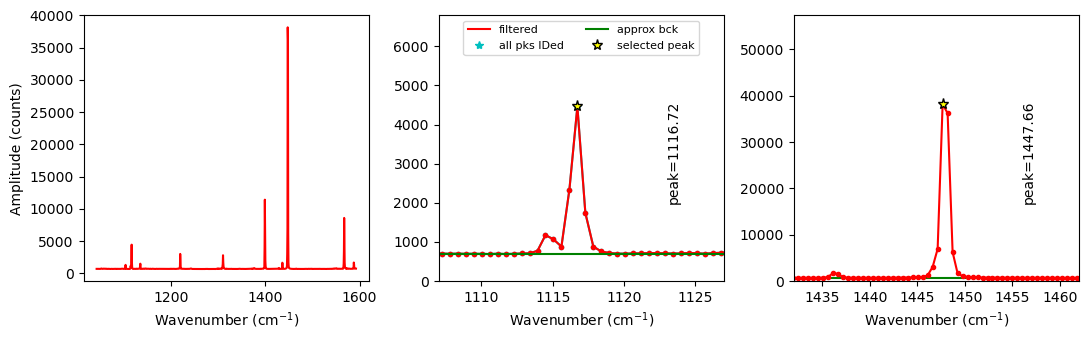

In [19]:
exclude_range_1=None
exclude_range_2=None

Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [20]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), x_span_pk1=None, x_span_pk2=None)

In [21]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=2, LH_offset_mini=[0.5, 3],
pk1_sigma=0.6, pk2_sigma=0.3,
lower_bck_pk1=(-40, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )

filename  1σ_Ne_Corr_test  1σ_Ne_Corr  pk2_peak_cent  pk2_amplitude  \
0  Ne1.txt          0.00004     0.00004    1447.912721   49263.941332   

   pk2_sigma pk2_gamma  error_pk2  Peak2_Prop_Lor  pk1_peak_cent  ...  \
0    0.41171      None    0.00181        0.386933    1116.659797  ...   

   pk1_gamma  error_pk1 Peak1_Prop_Lor     deltaNe  Ne_Corr  Ne_Corr_min  \
0       None   0.013091       0.321625  331.252923  0.99766     0.997615   

   Ne_Corr_max  residual_pk2  residual_pk1  residual_pk1+pk2  
0     0.997704      104.2414     12.060576        116.301976  

[1 rows x 22 columns]

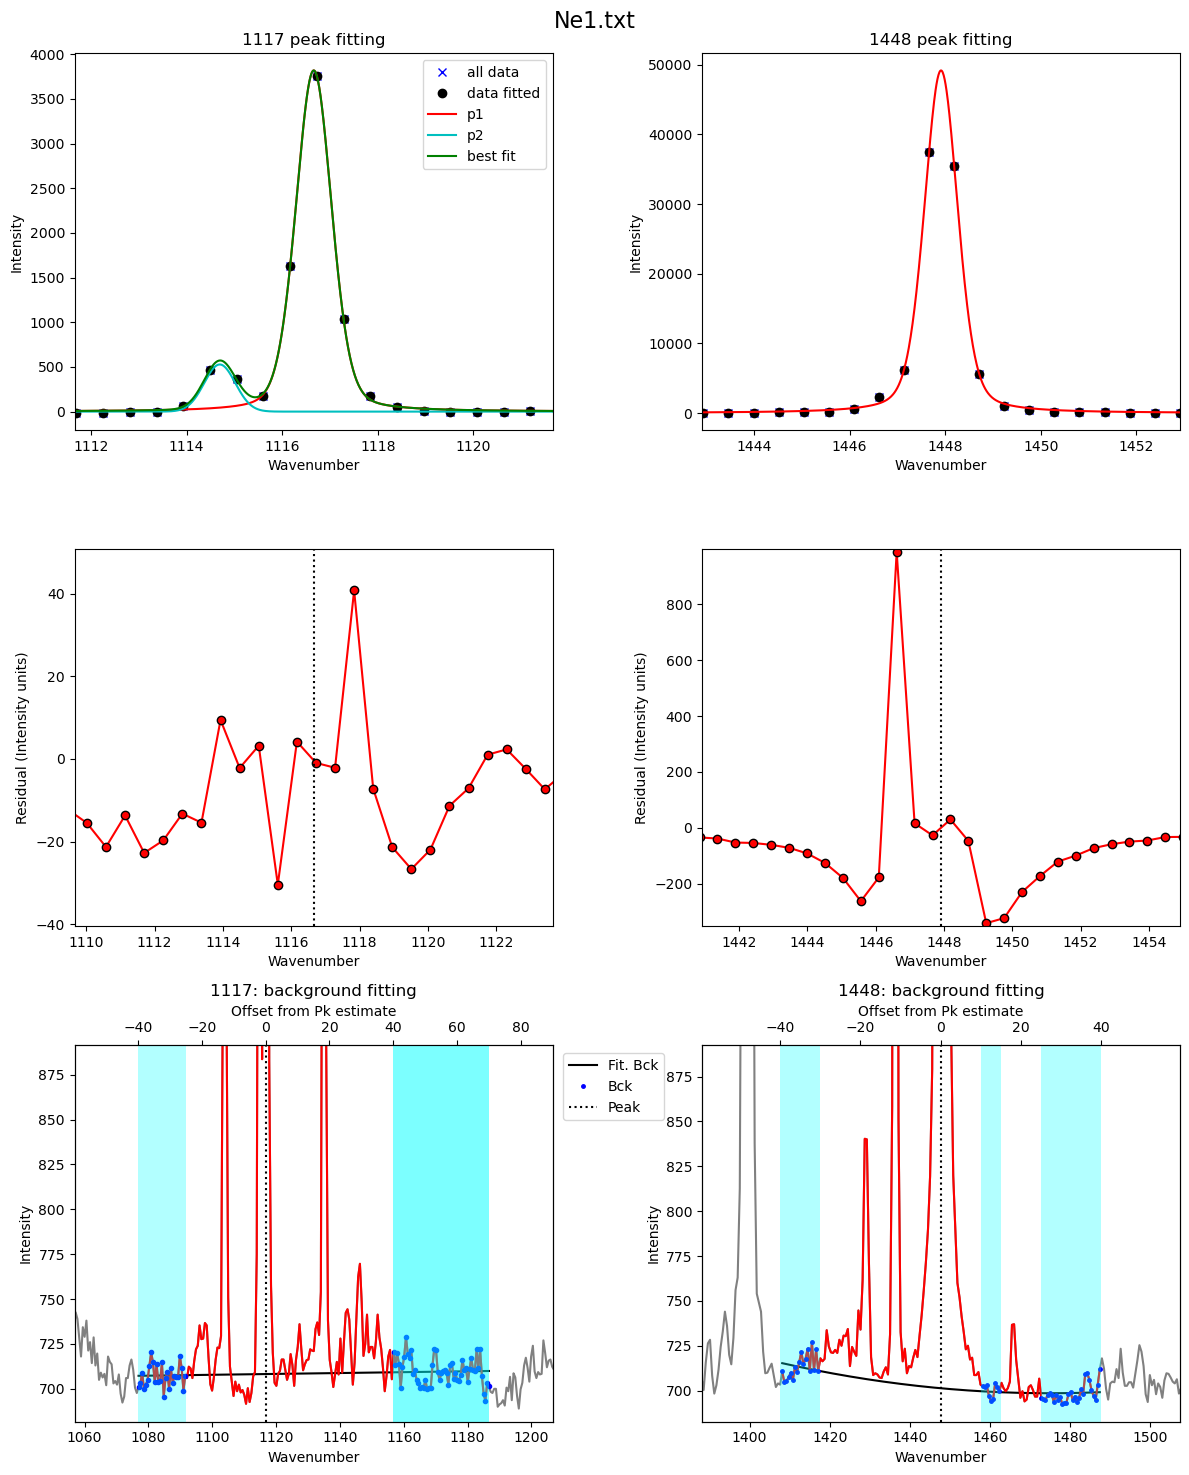

In [22]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=prefix,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[0], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[0],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[0],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[0],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [23]:
## Now tweak the values of the sigma to help with the looping - then for looping we let these parameters only vary +-20% between spectra
Ne_Config_est.pk1_sigma=df_test_params['pk1_sigma'][0]
Ne_Config_est.pk2_sigma=df_test_params['pk2_sigma'][0]


## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

  0%|          | 0/26 [00:00<?, ?it/s]

c:\users\penny\box\berkeley_new\diadfit_outer\src\DiadFit\ne_lines.py:1220: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ((ax3, ax2), (ax5, ax4), (ax1, ax0)) = plt.subplots(3,2, figsize = (12,15)) # adjust dimensions of figure here


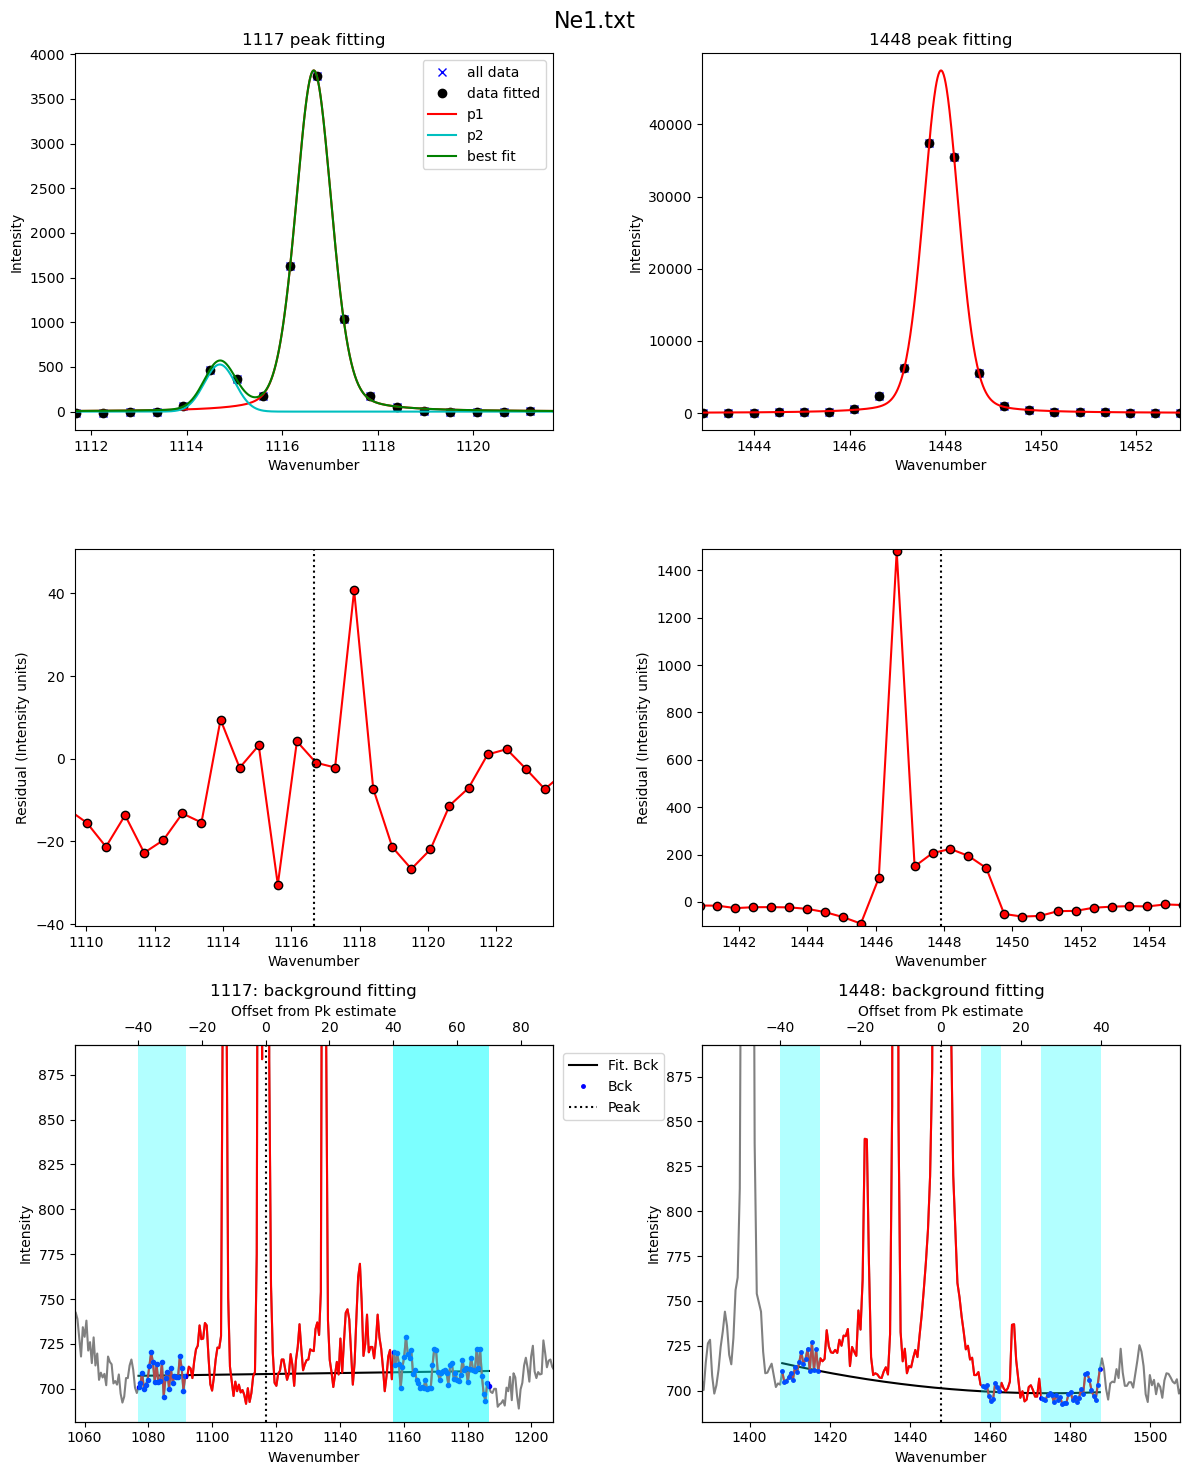

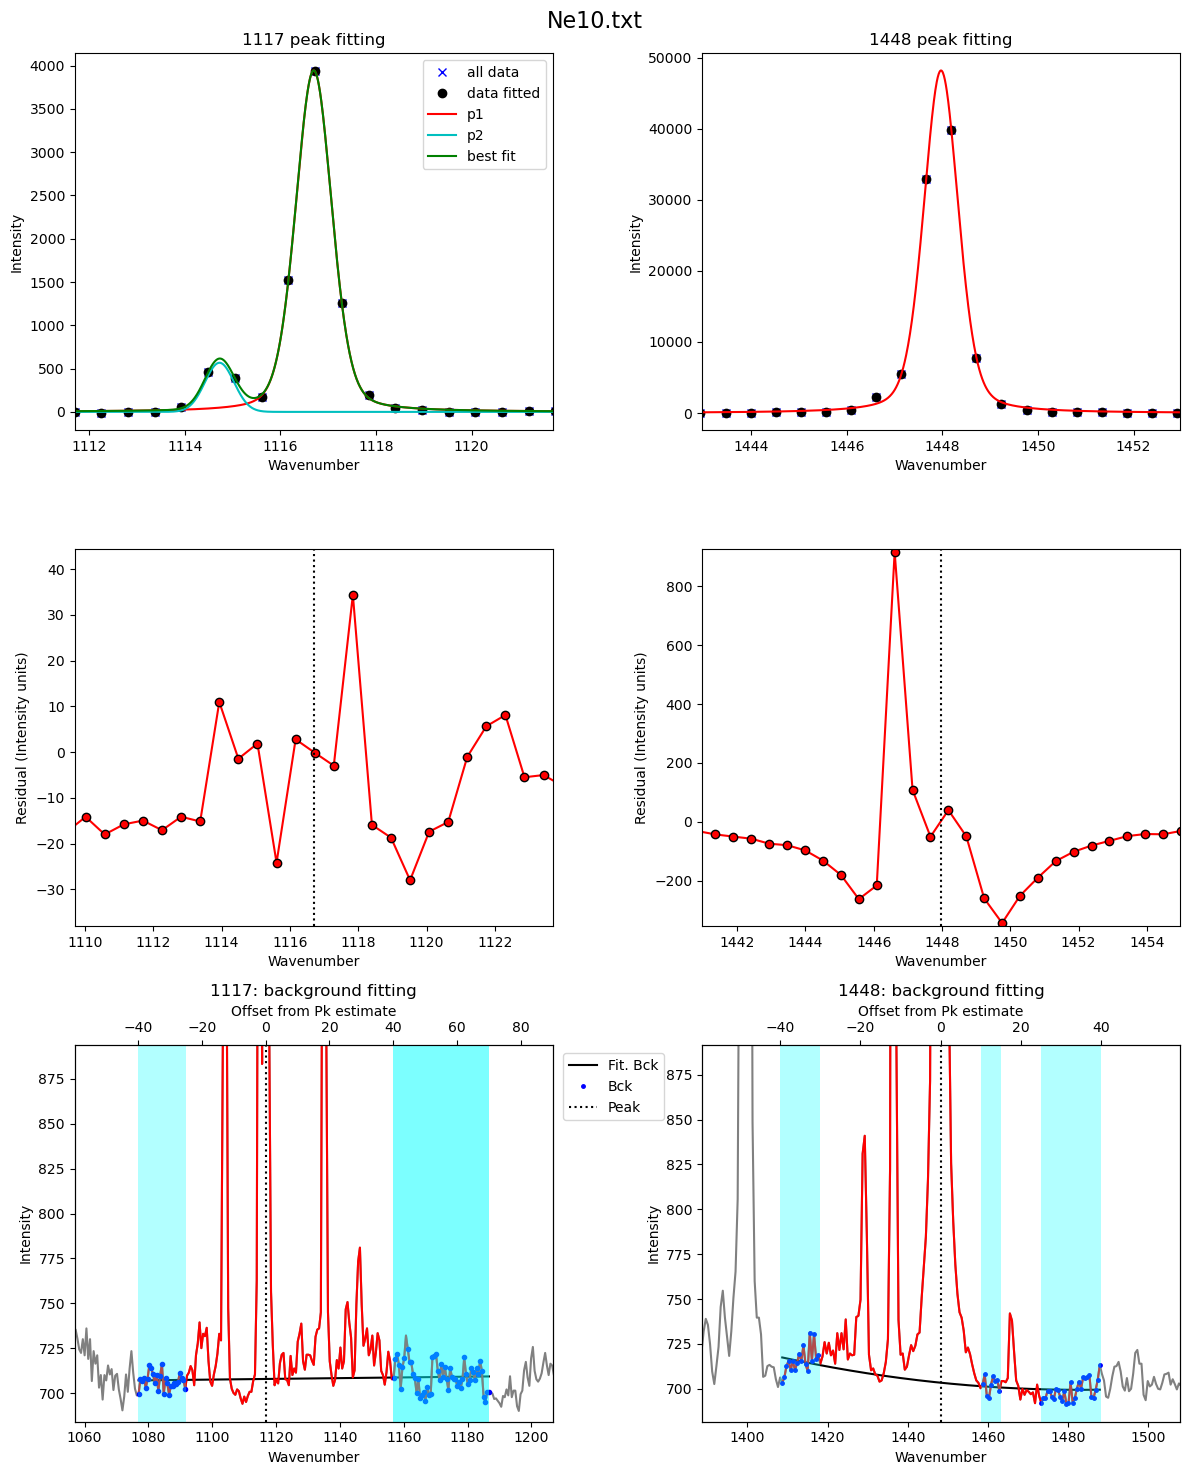

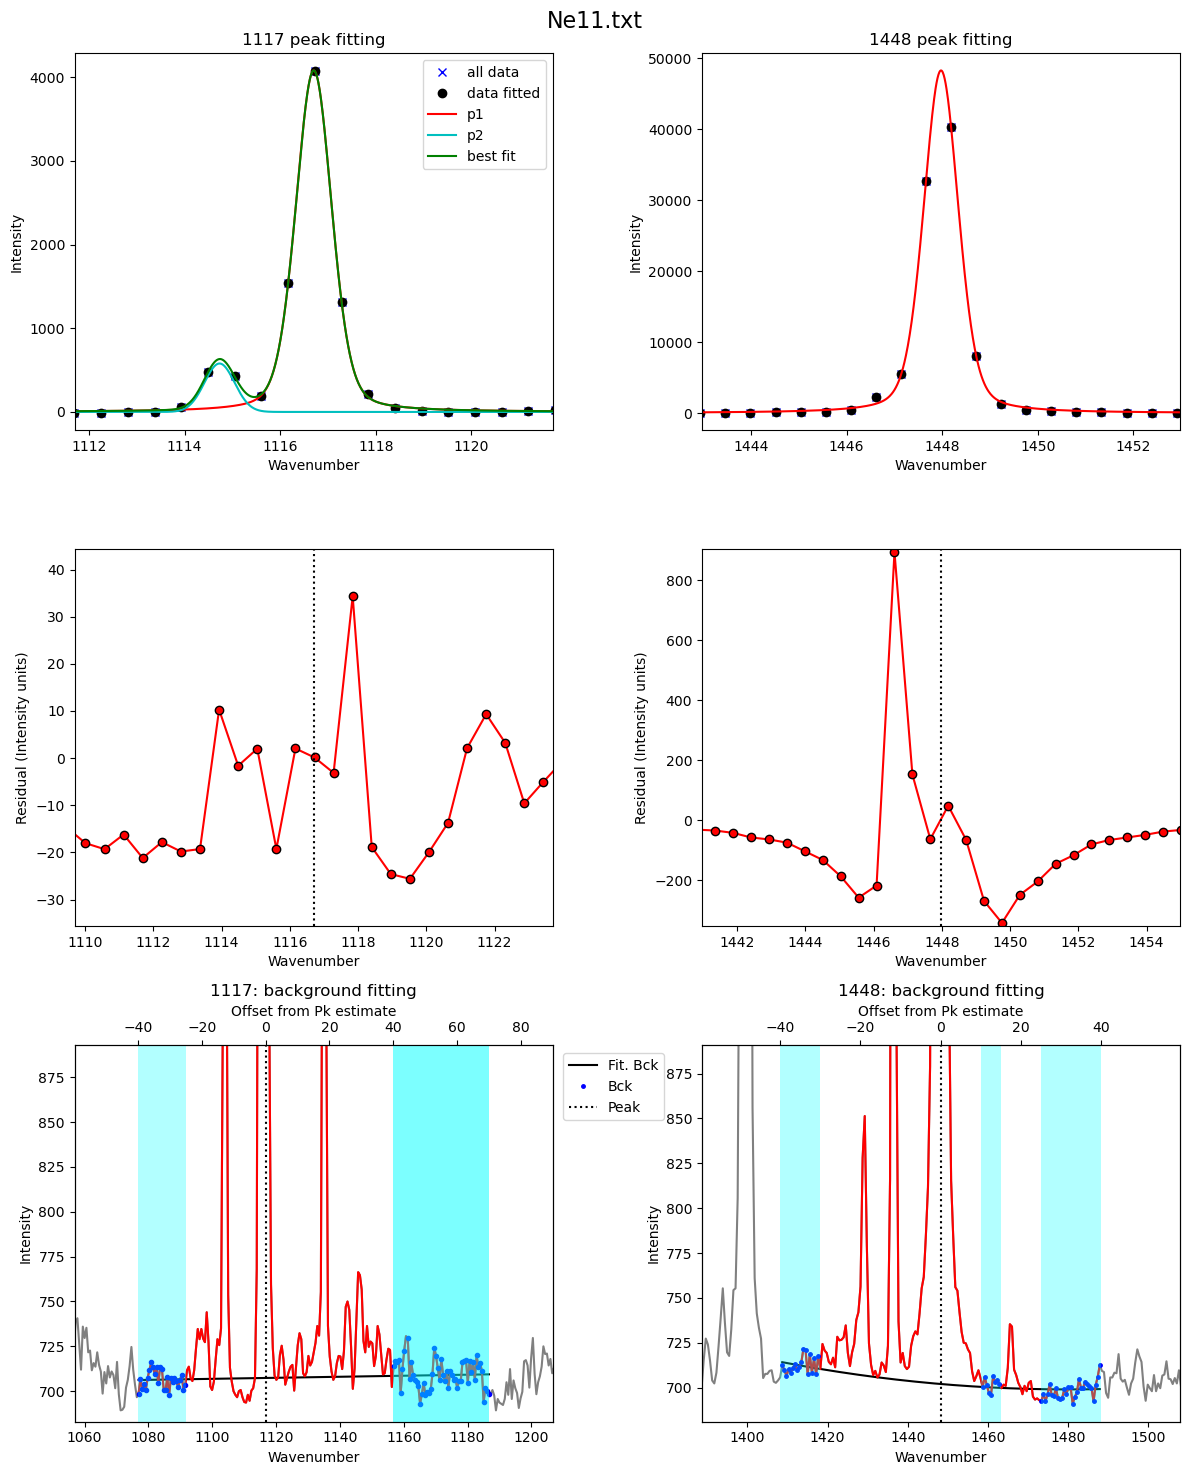

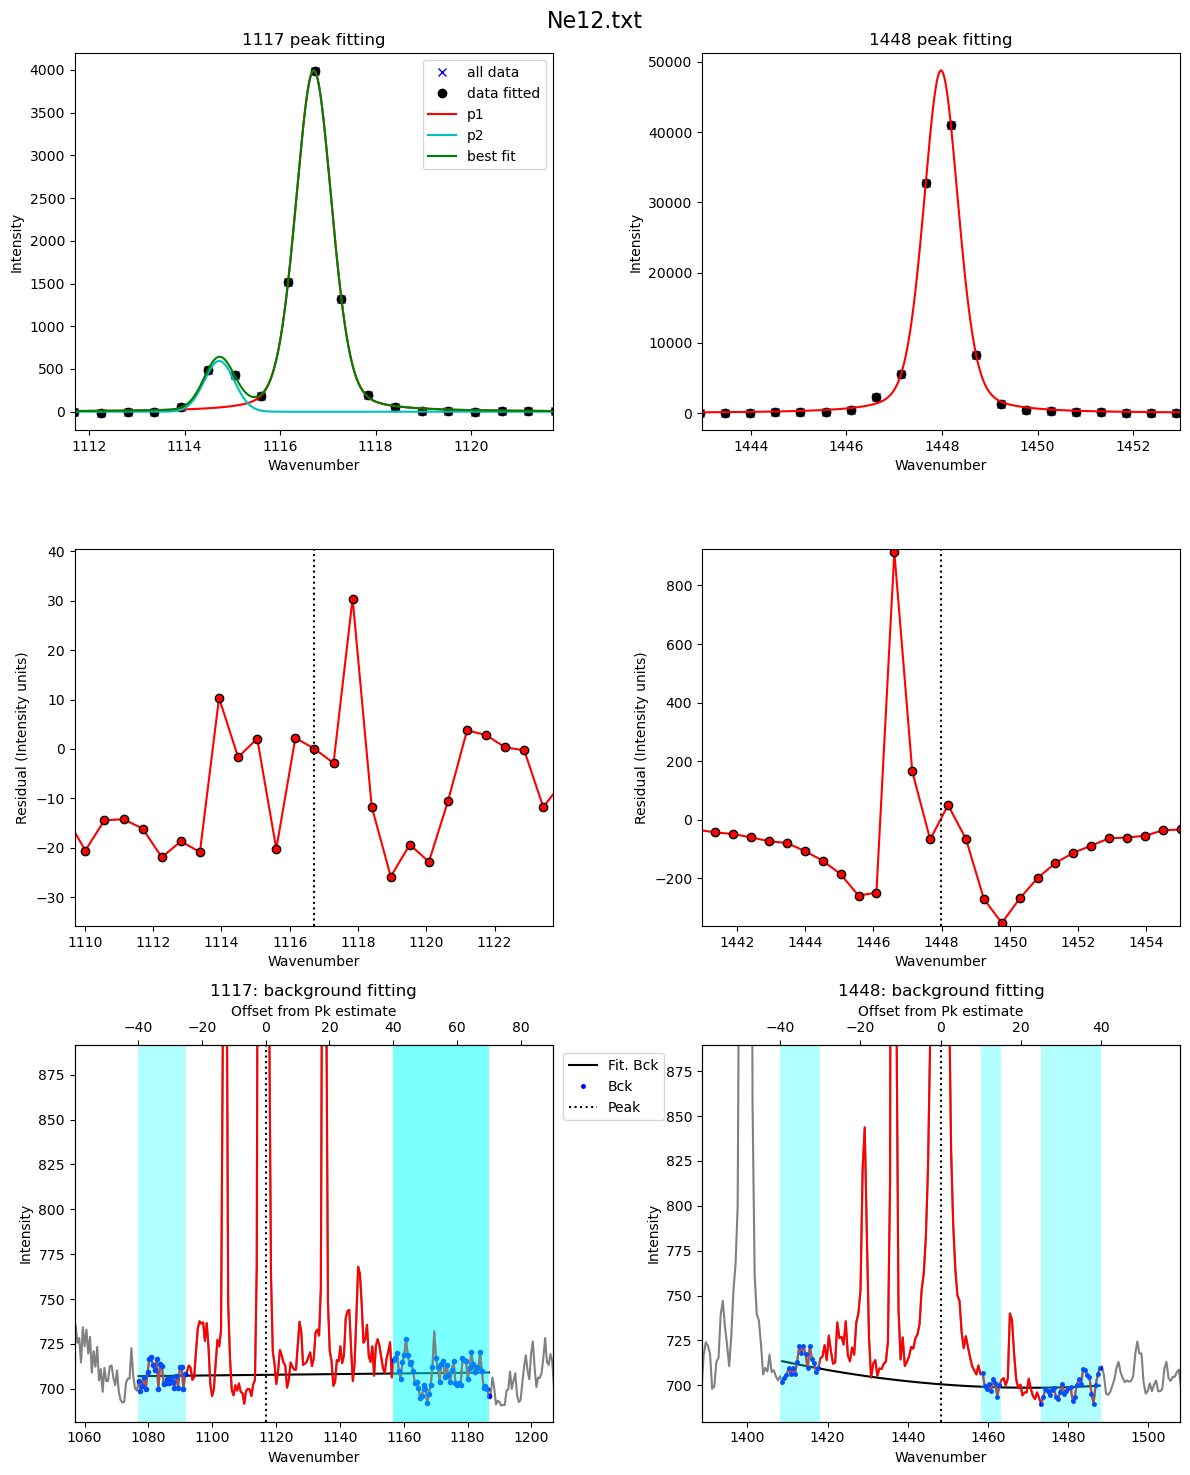

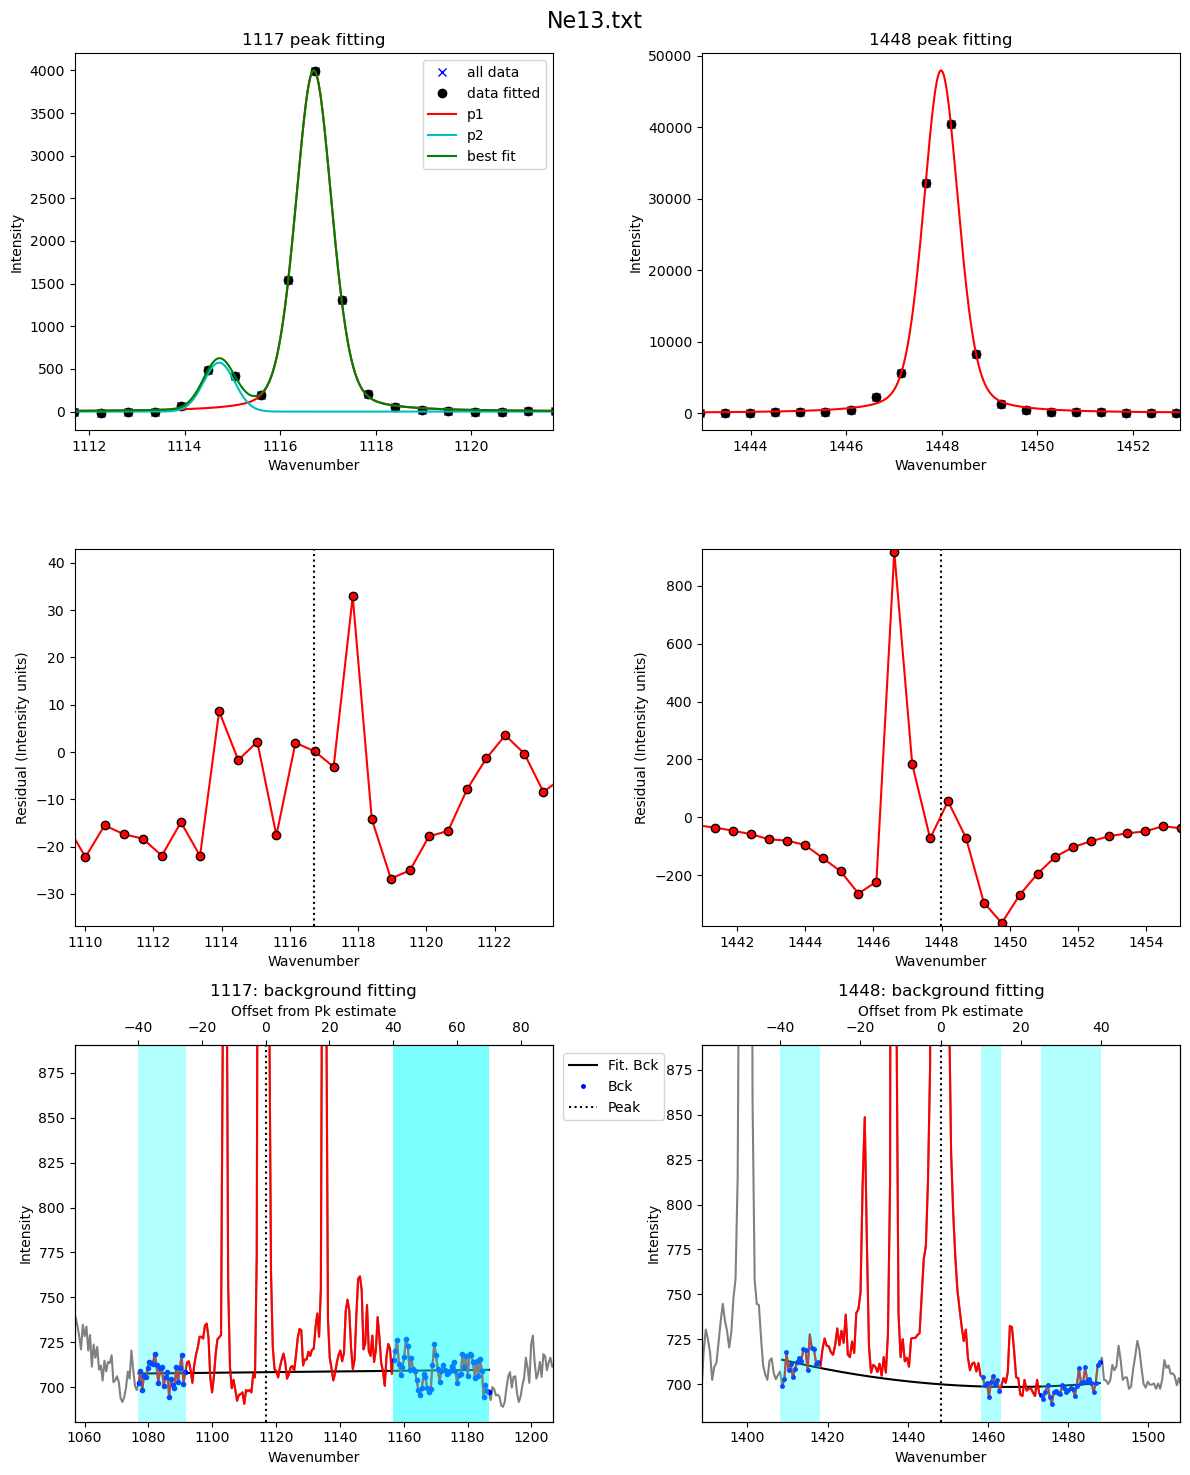

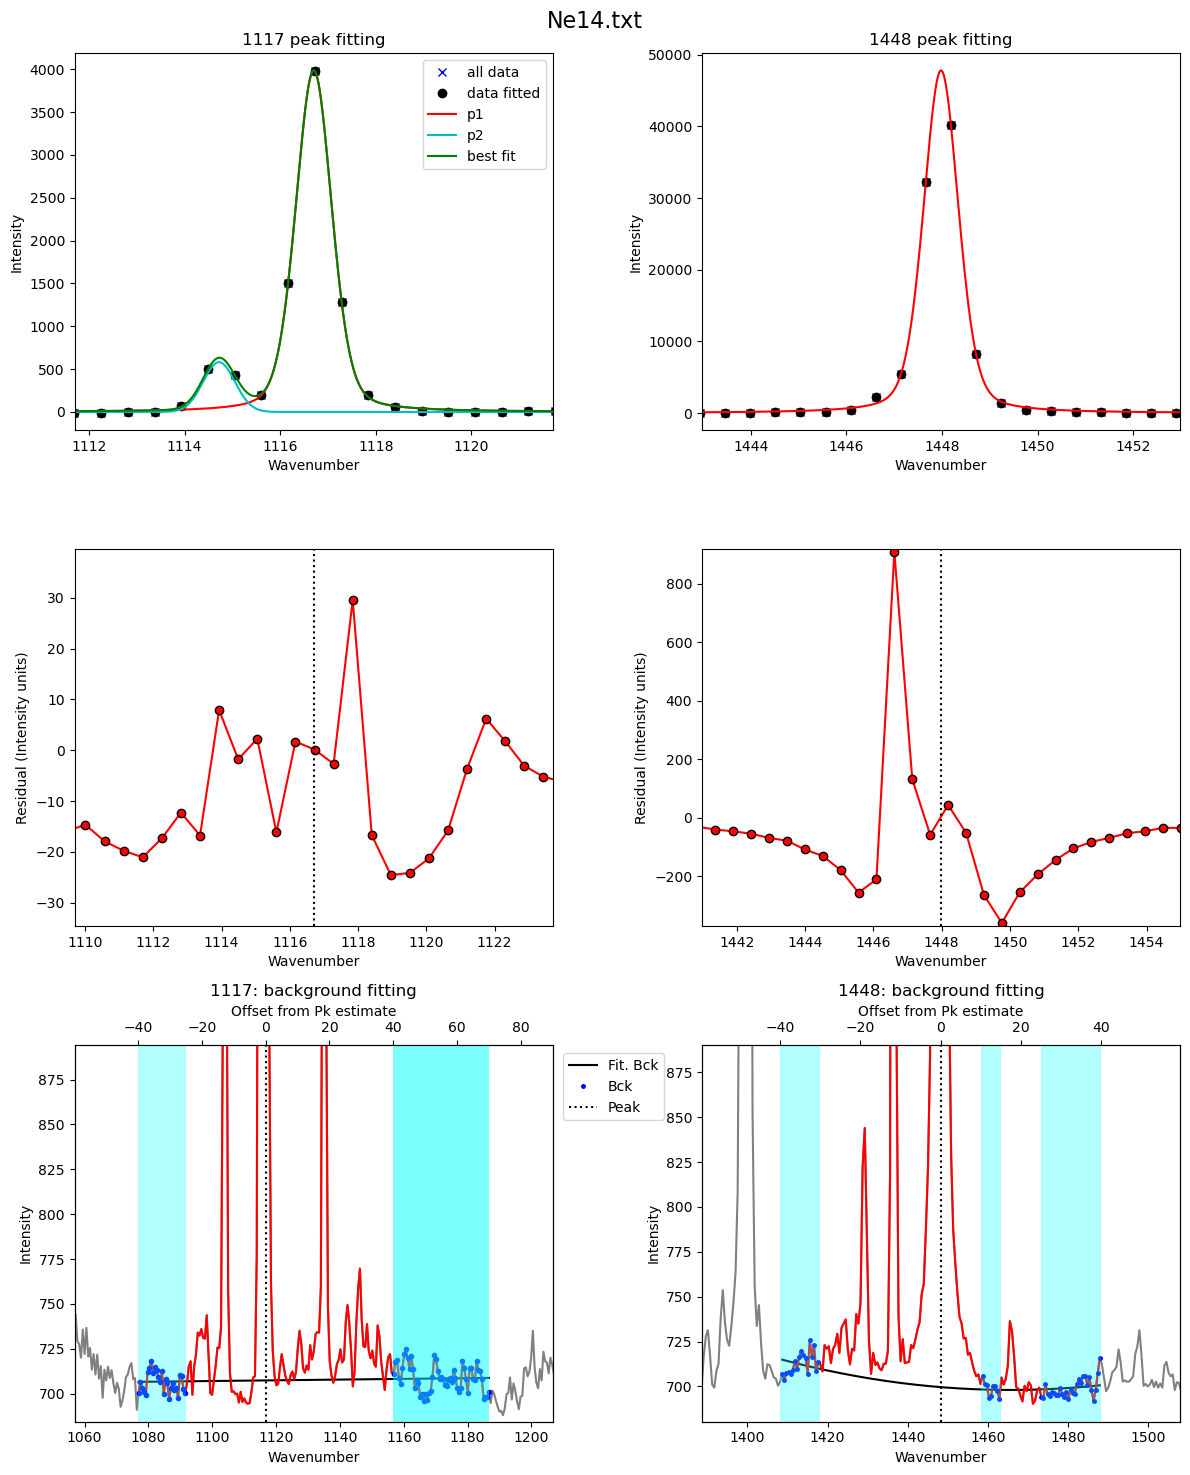

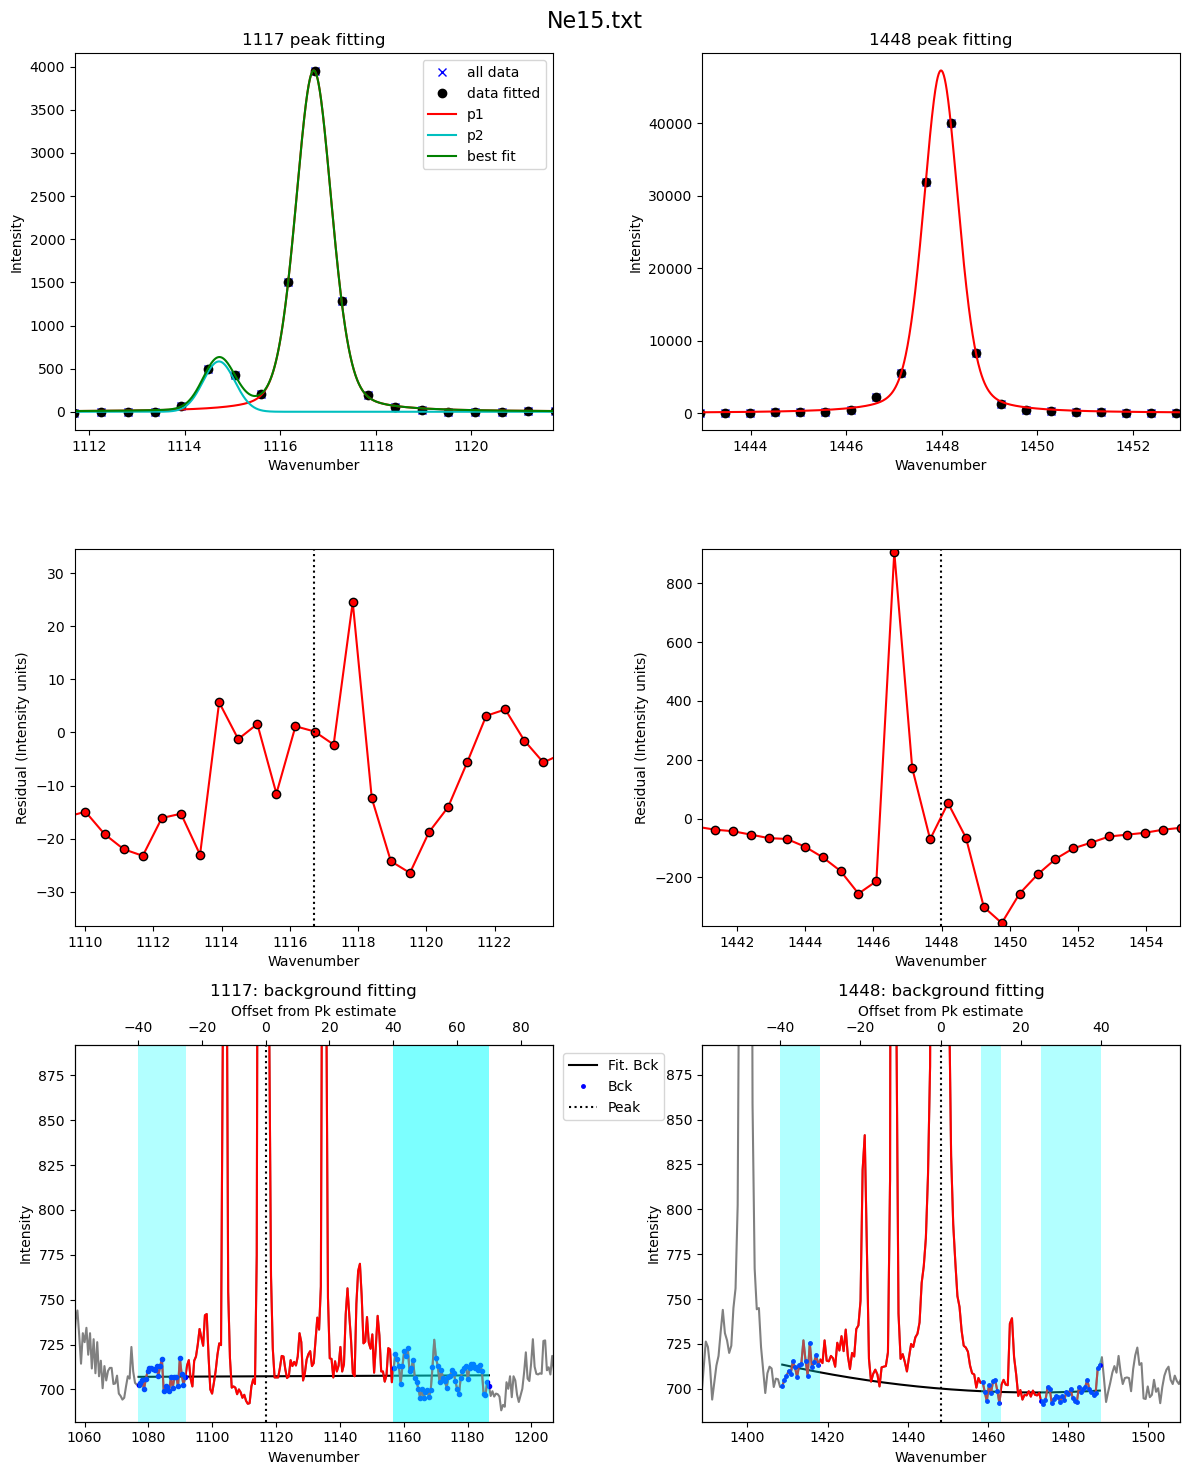

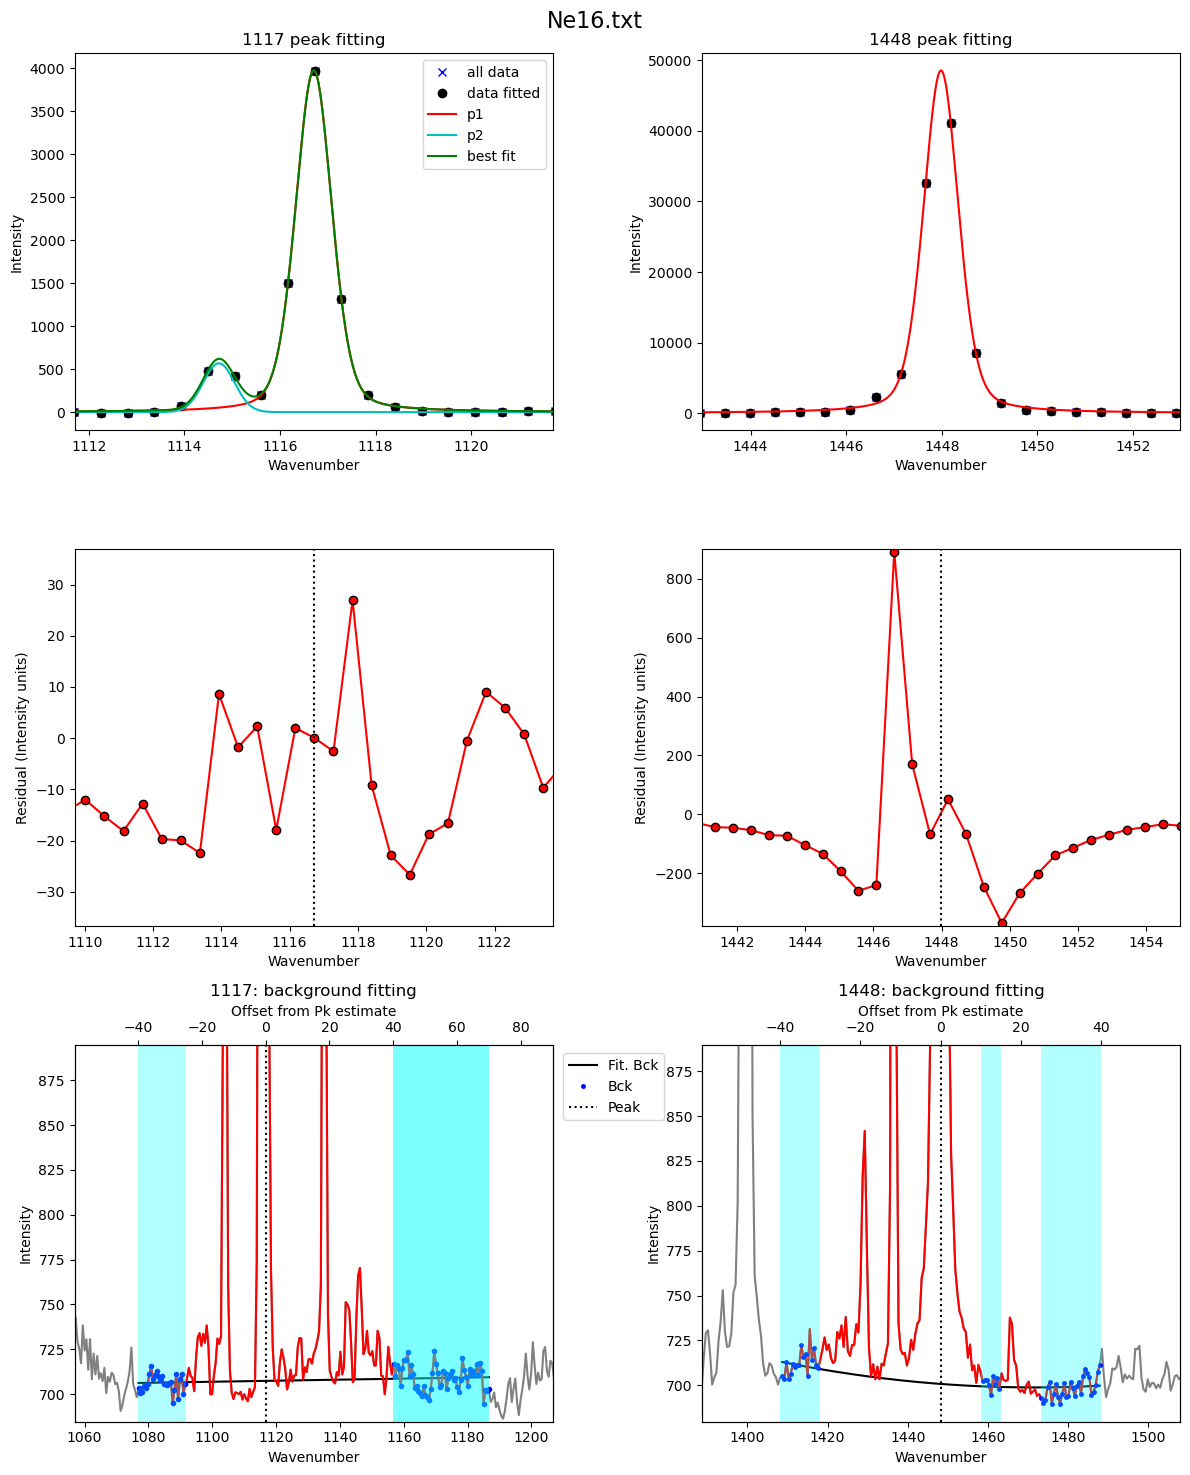

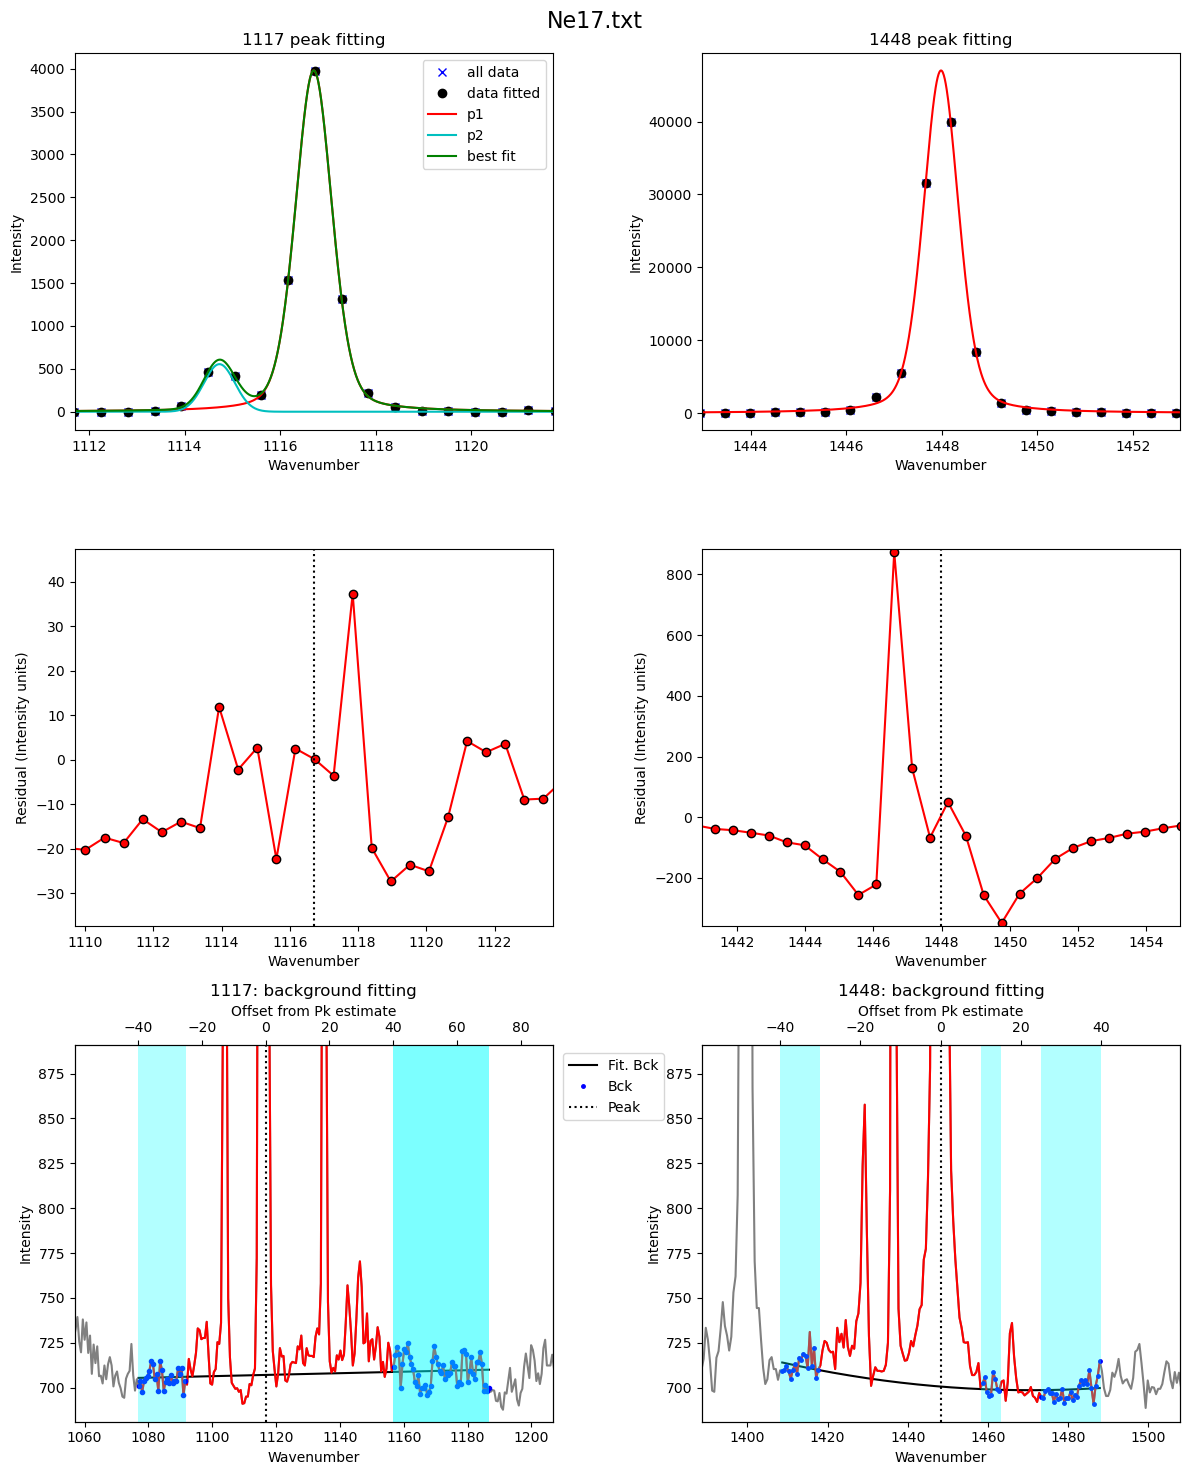

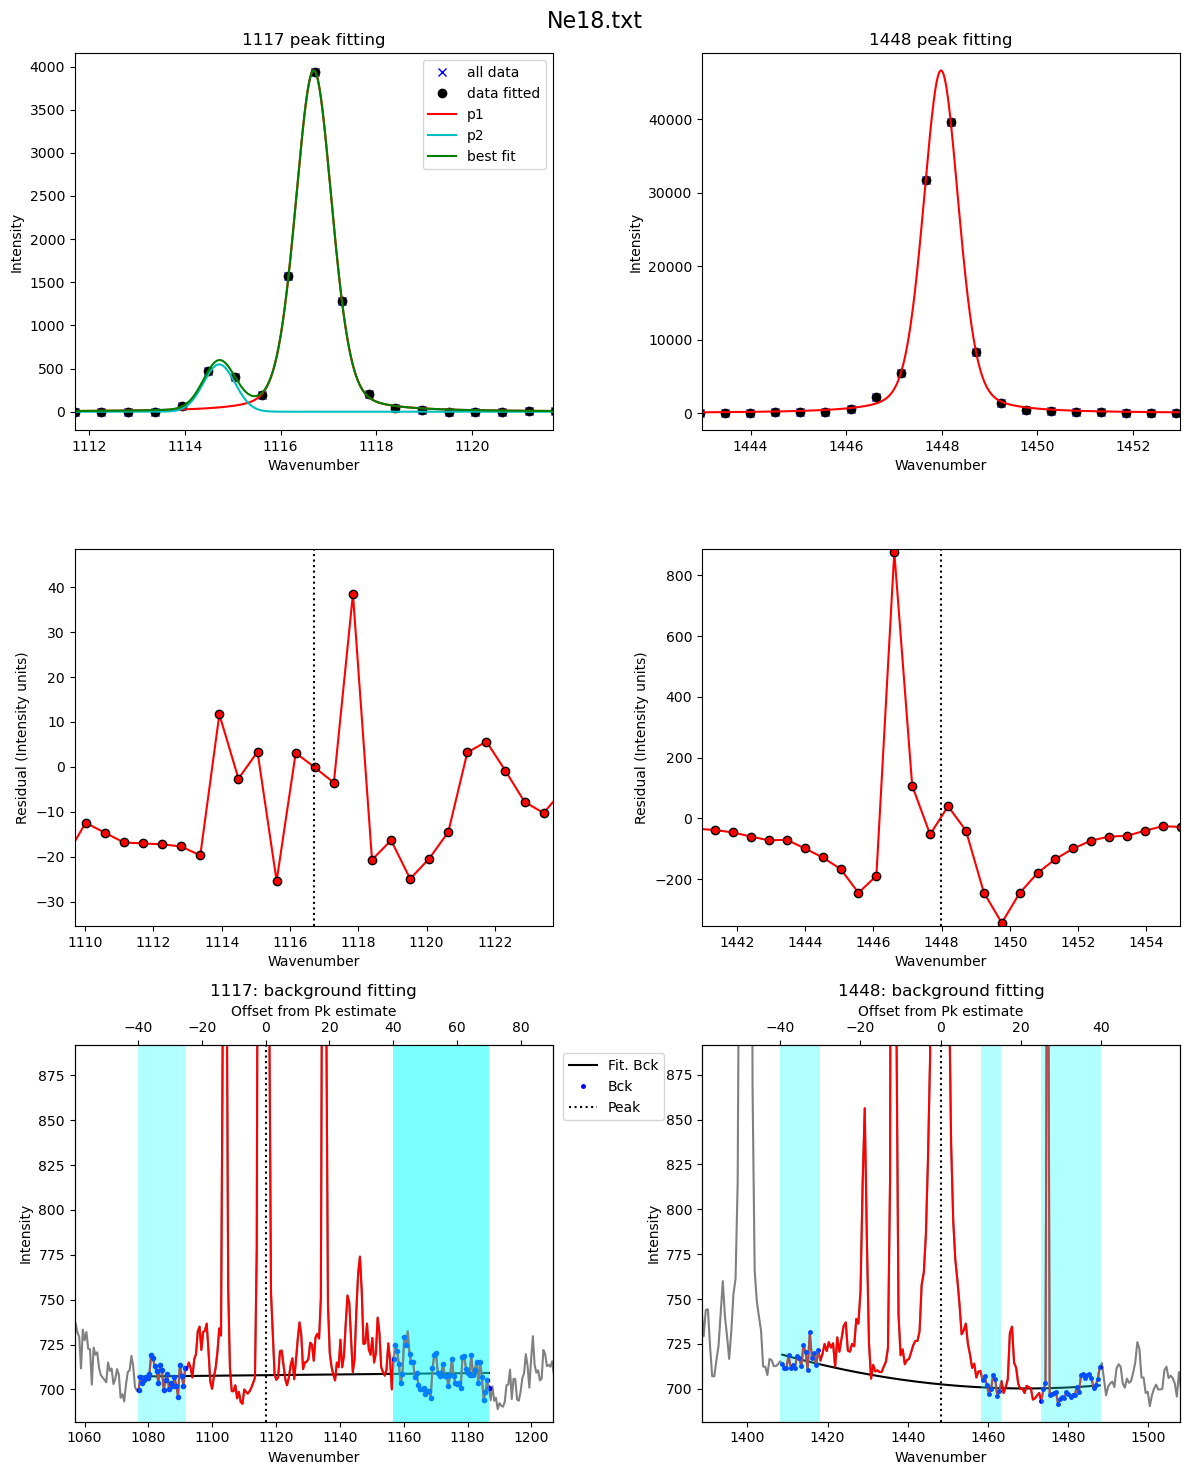

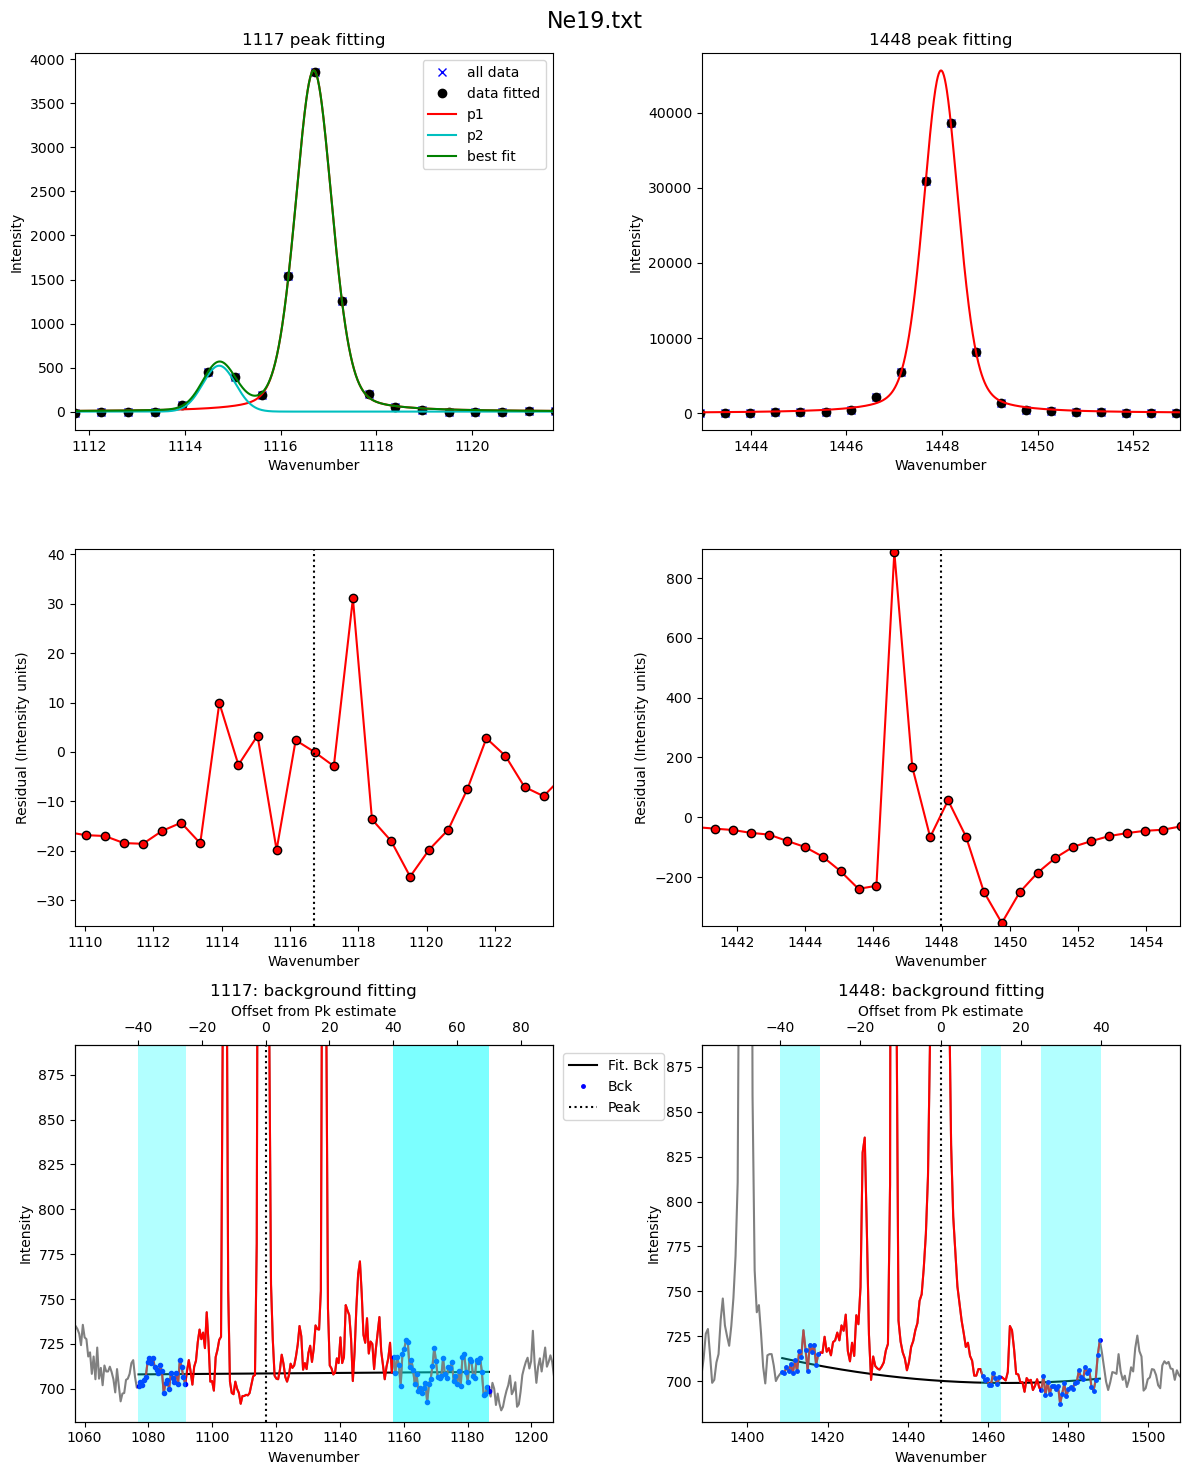

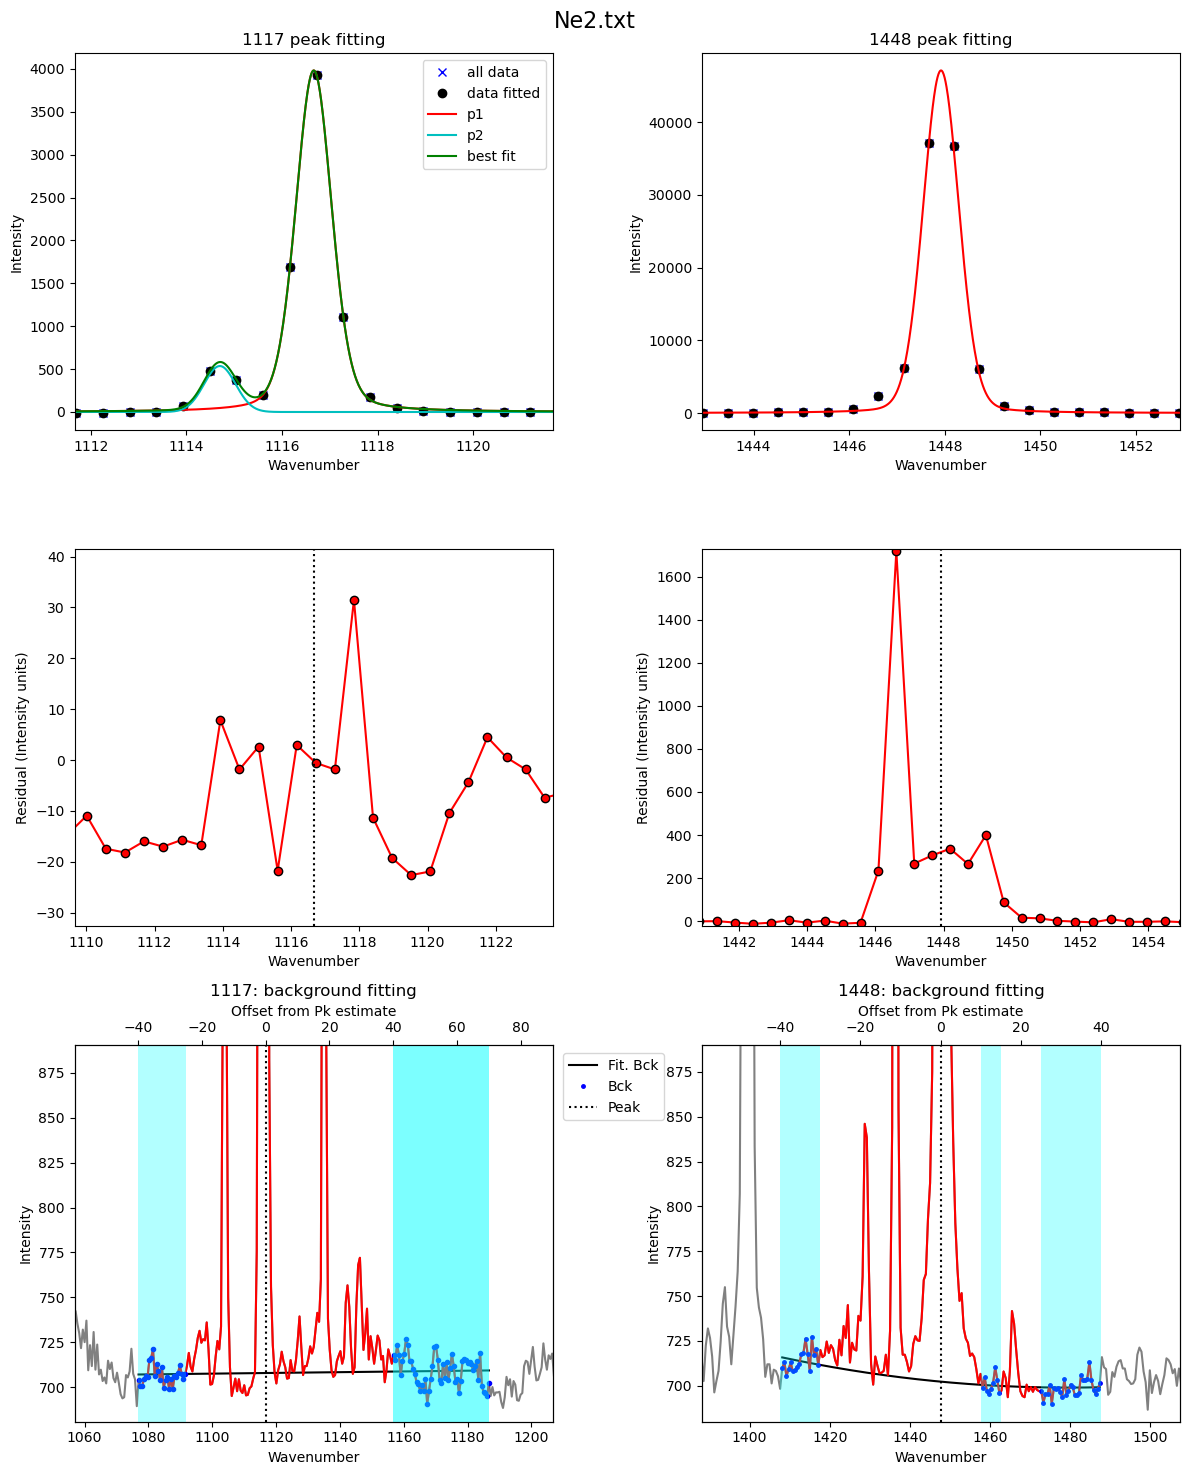

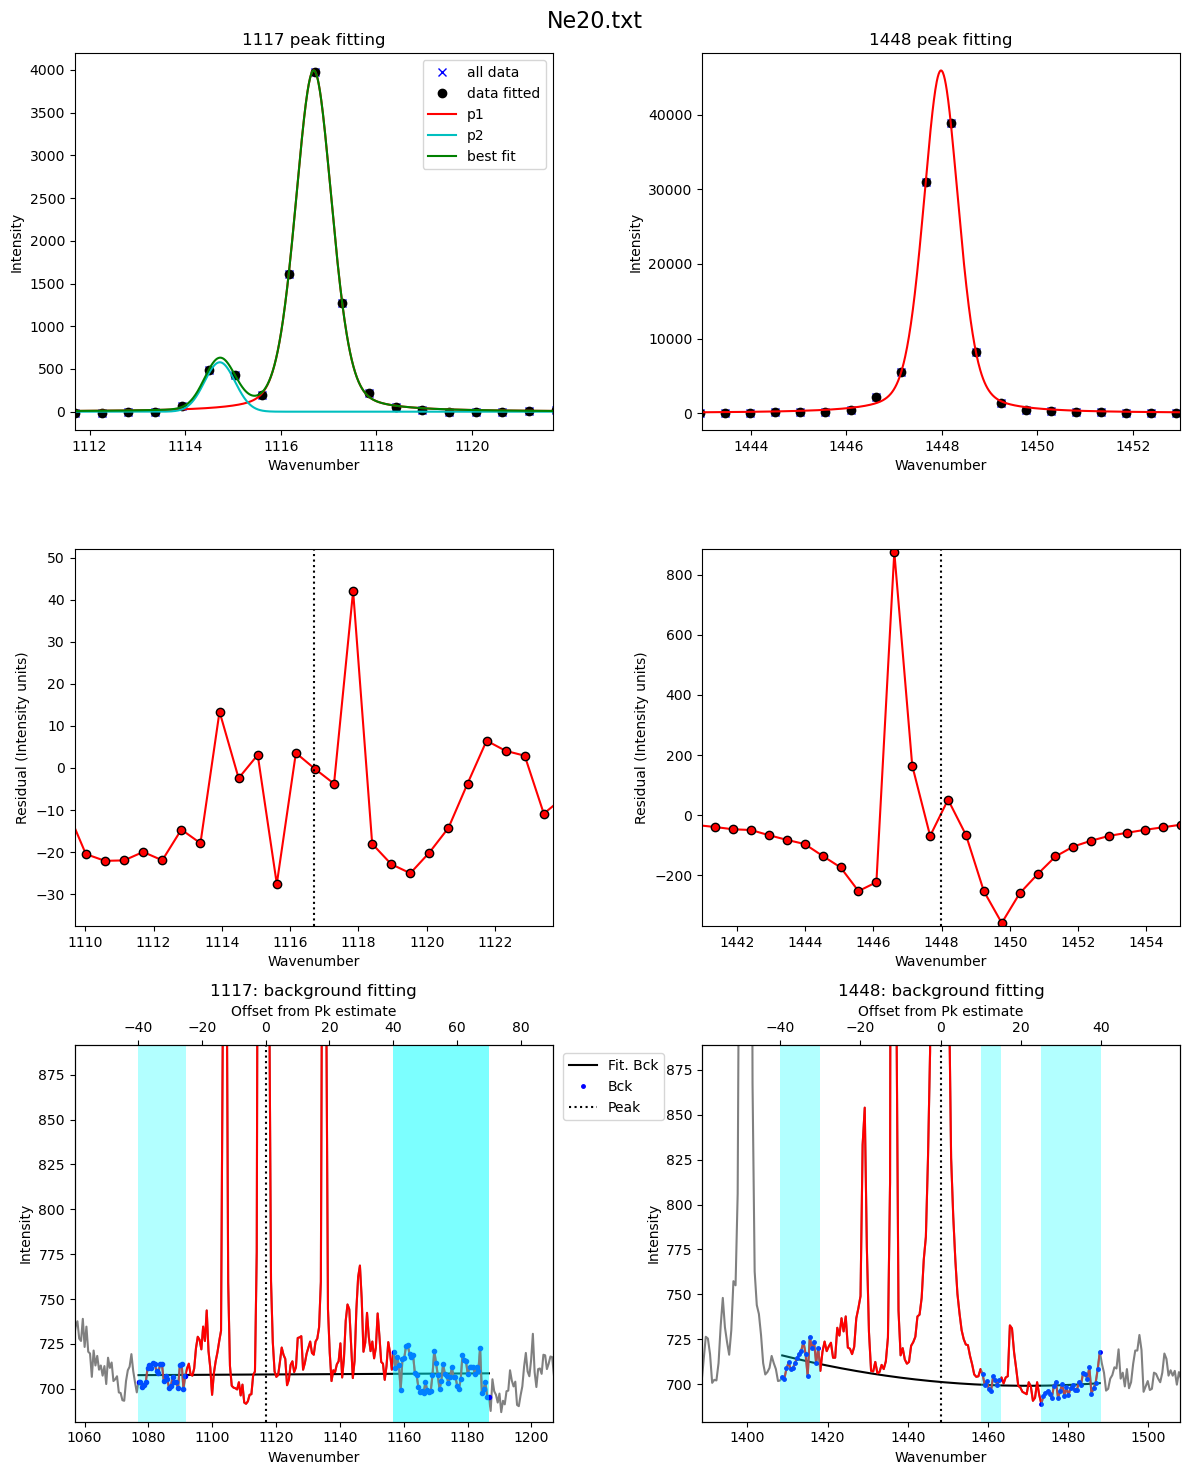

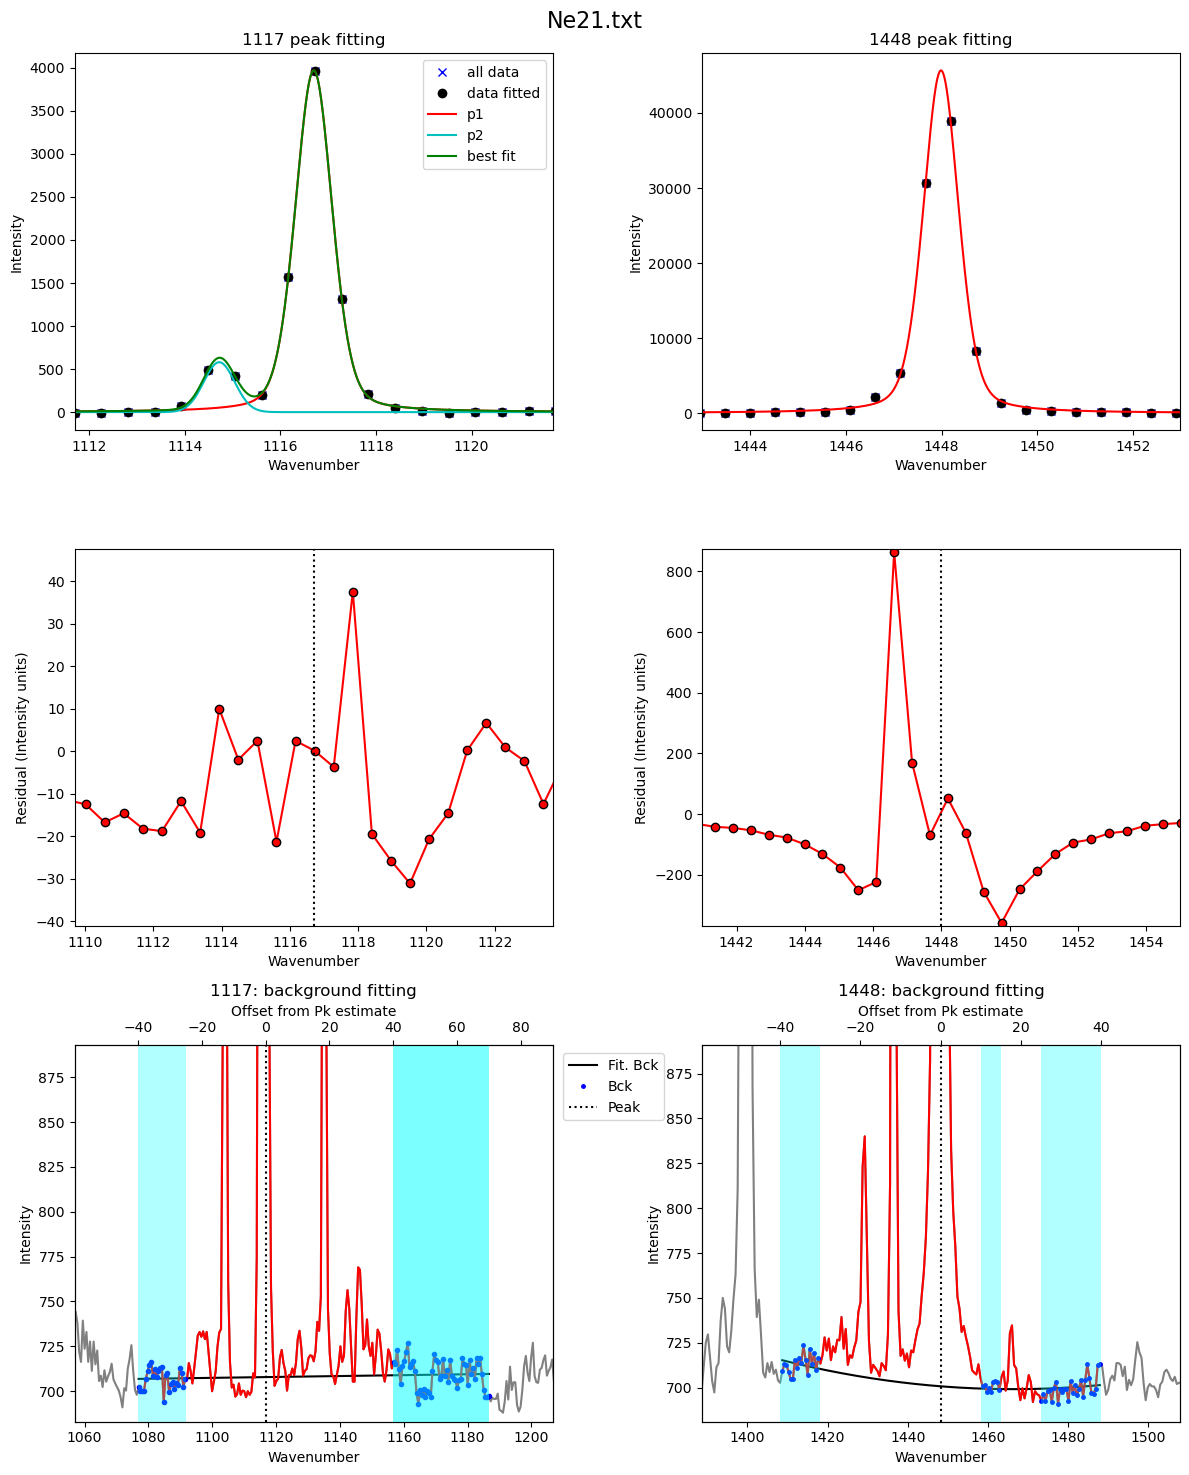

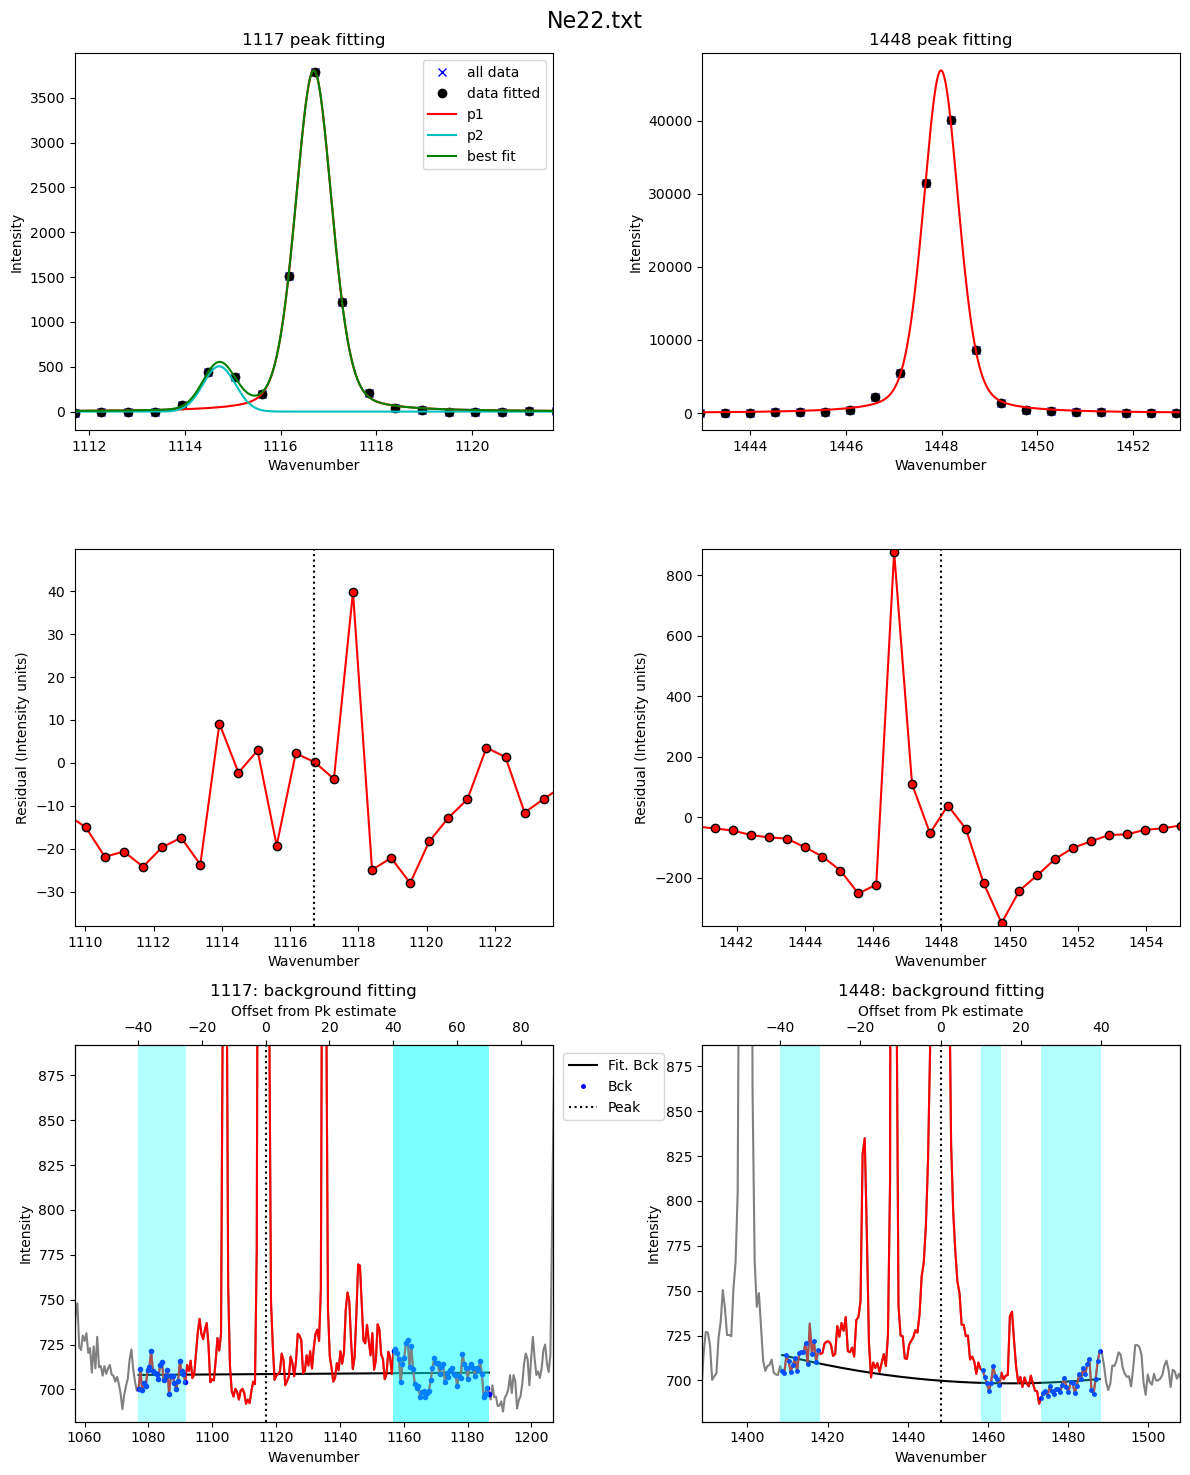

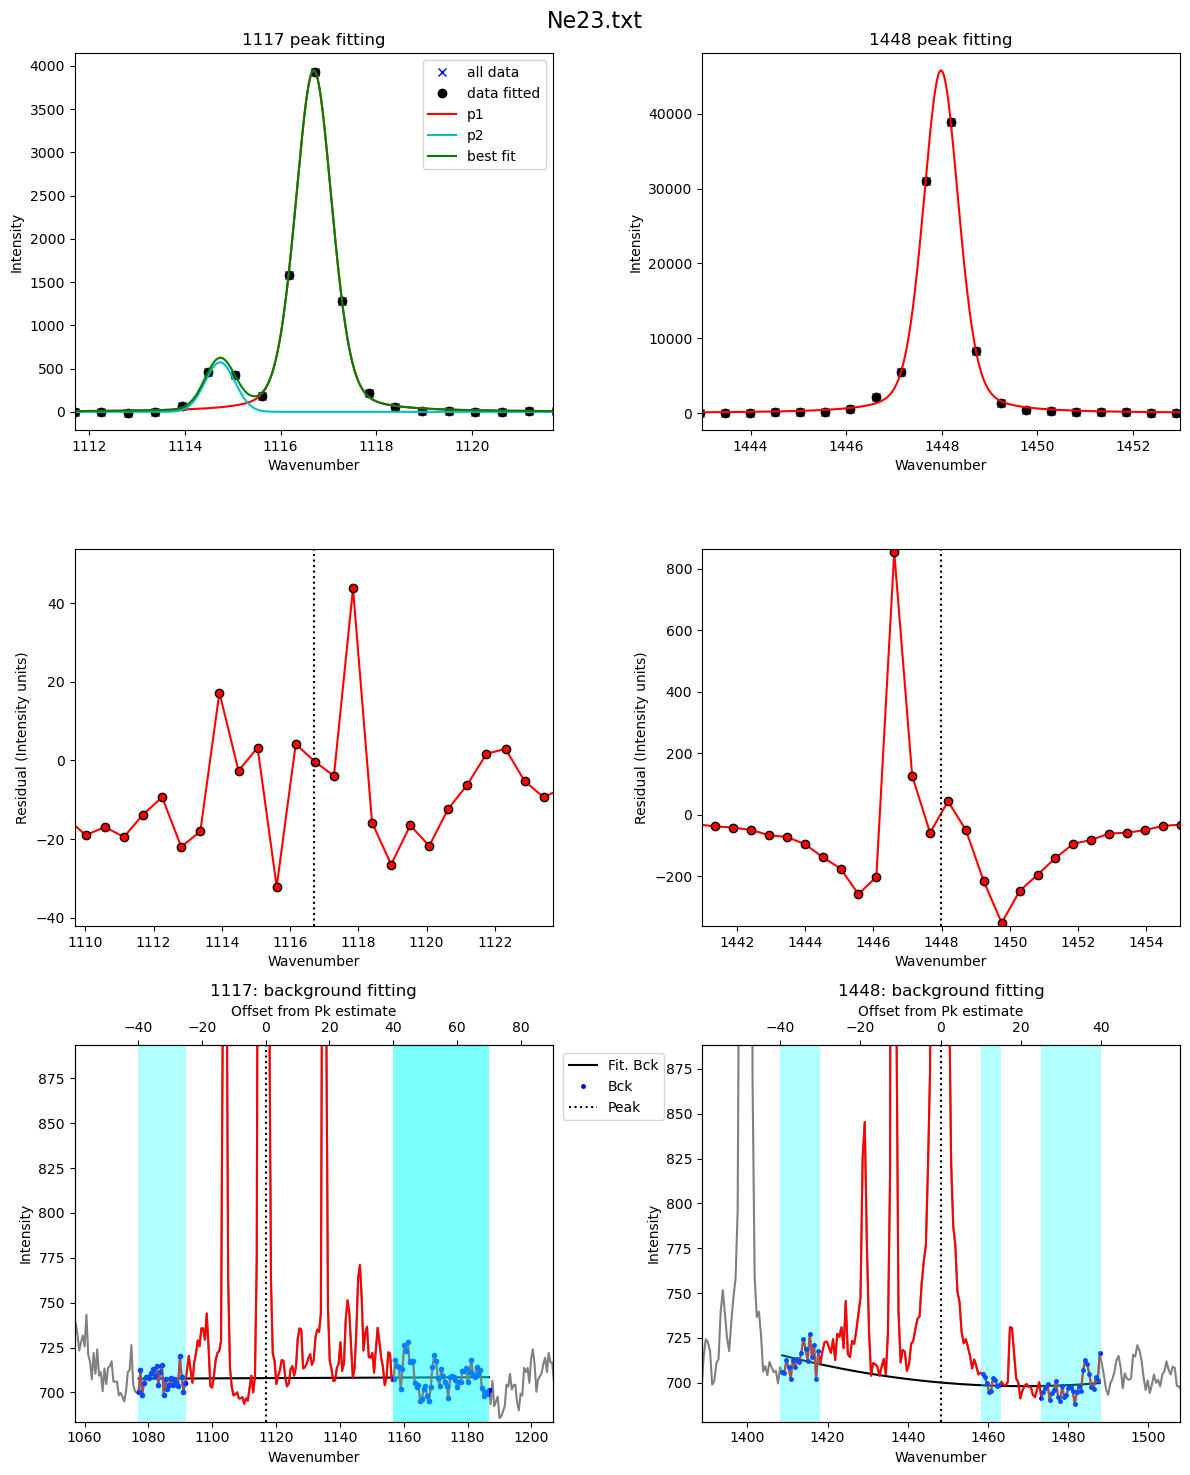

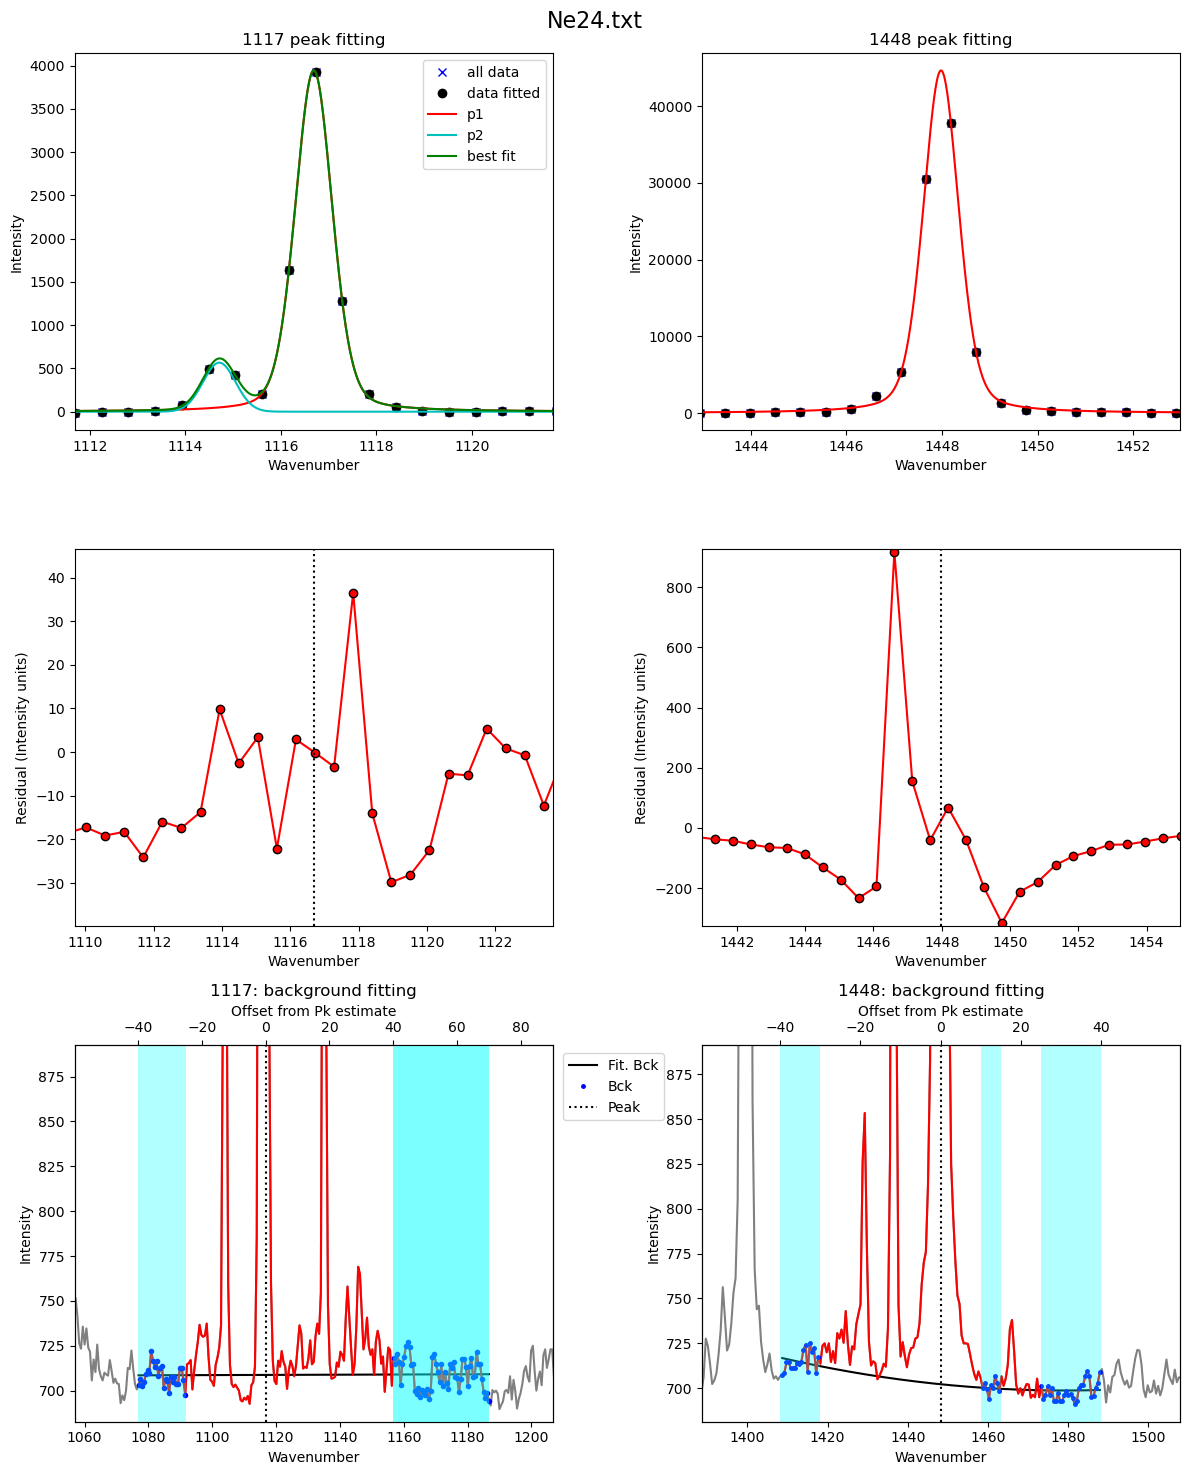

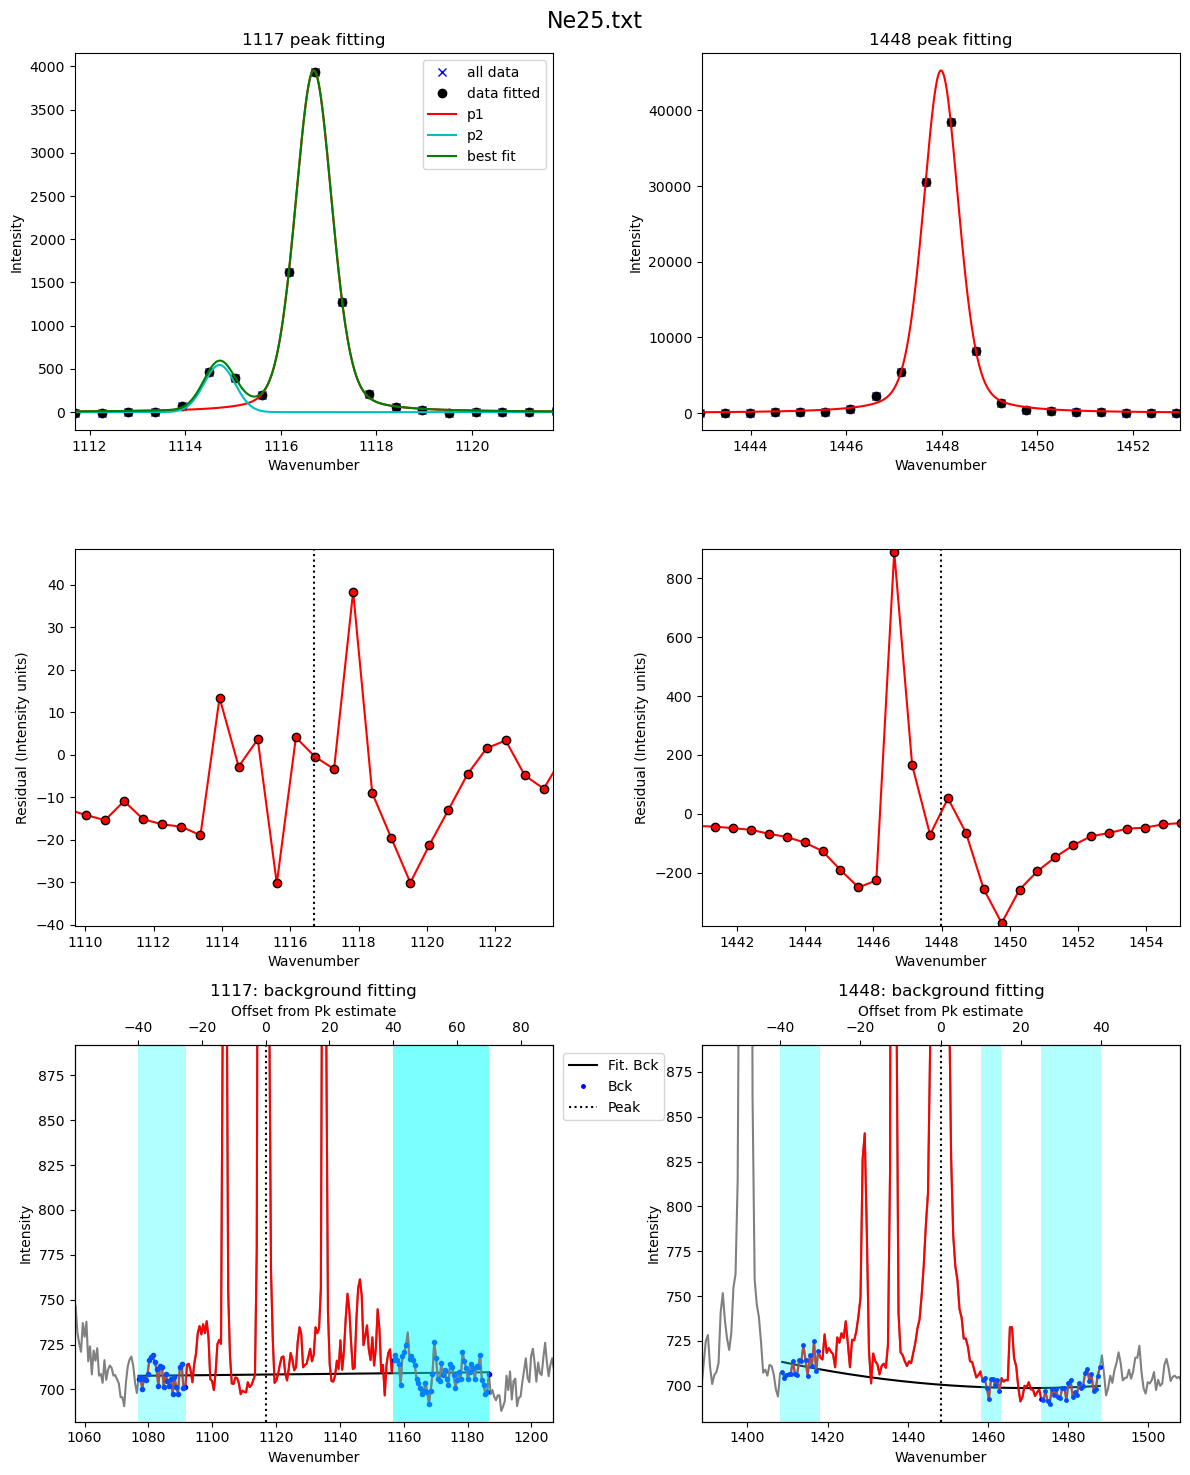

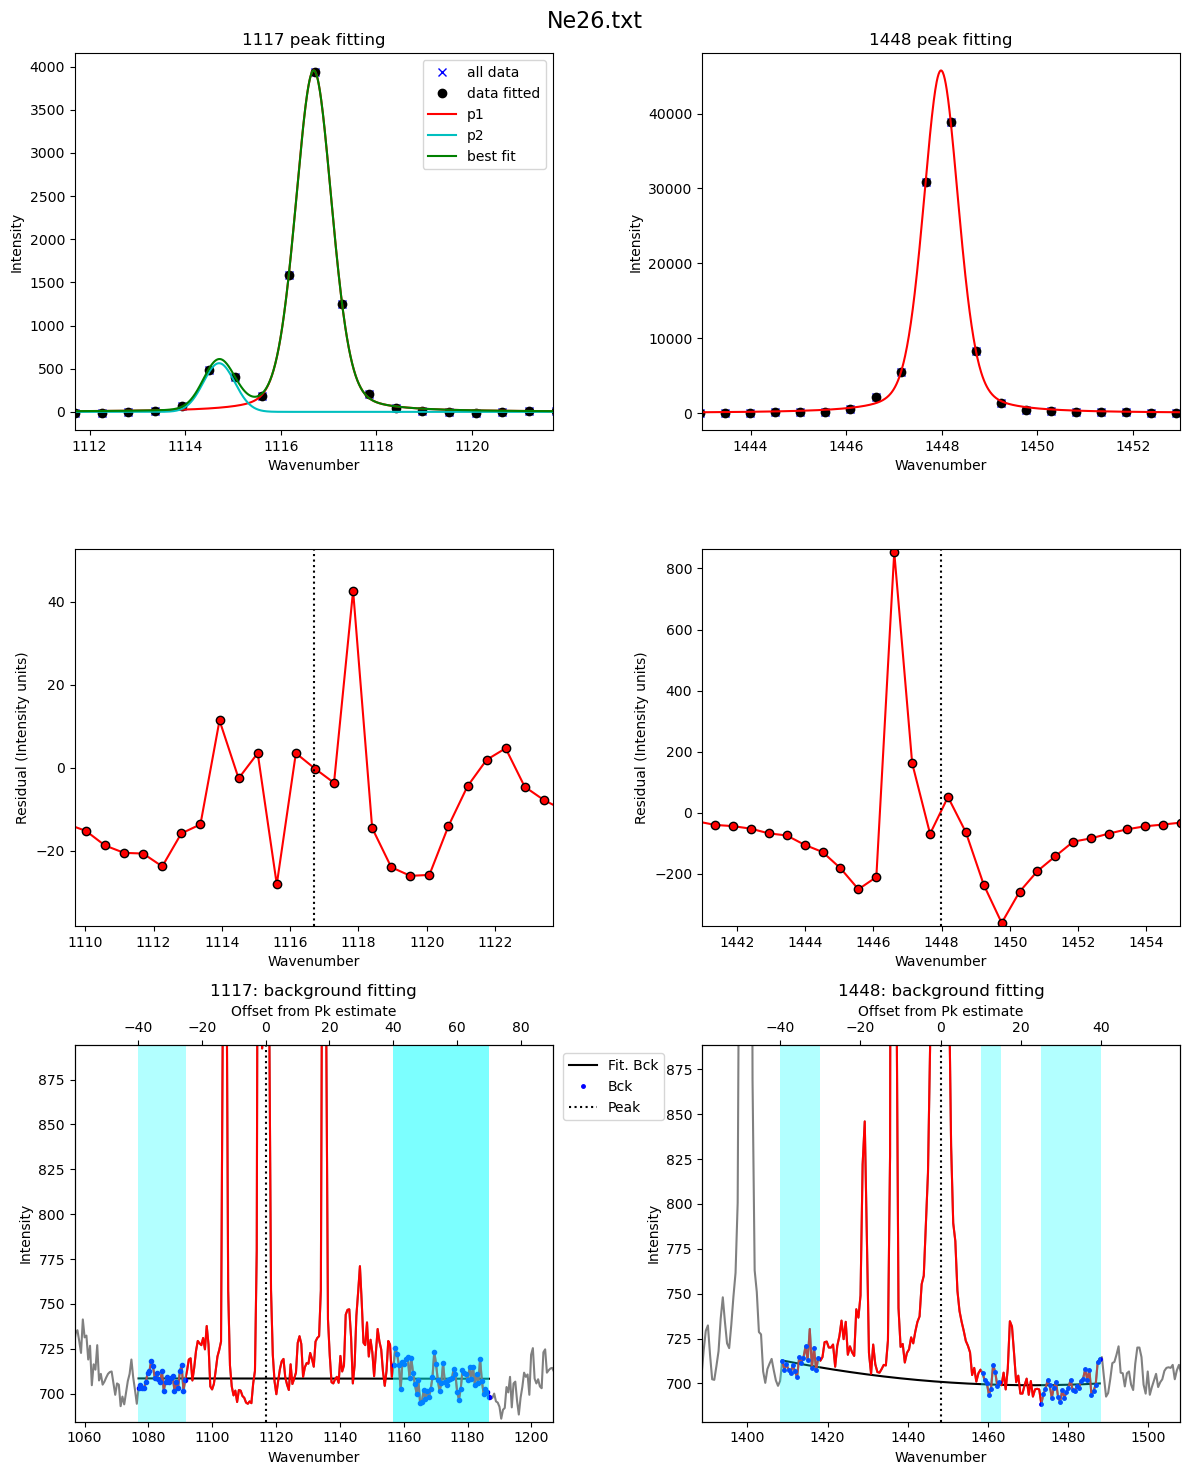

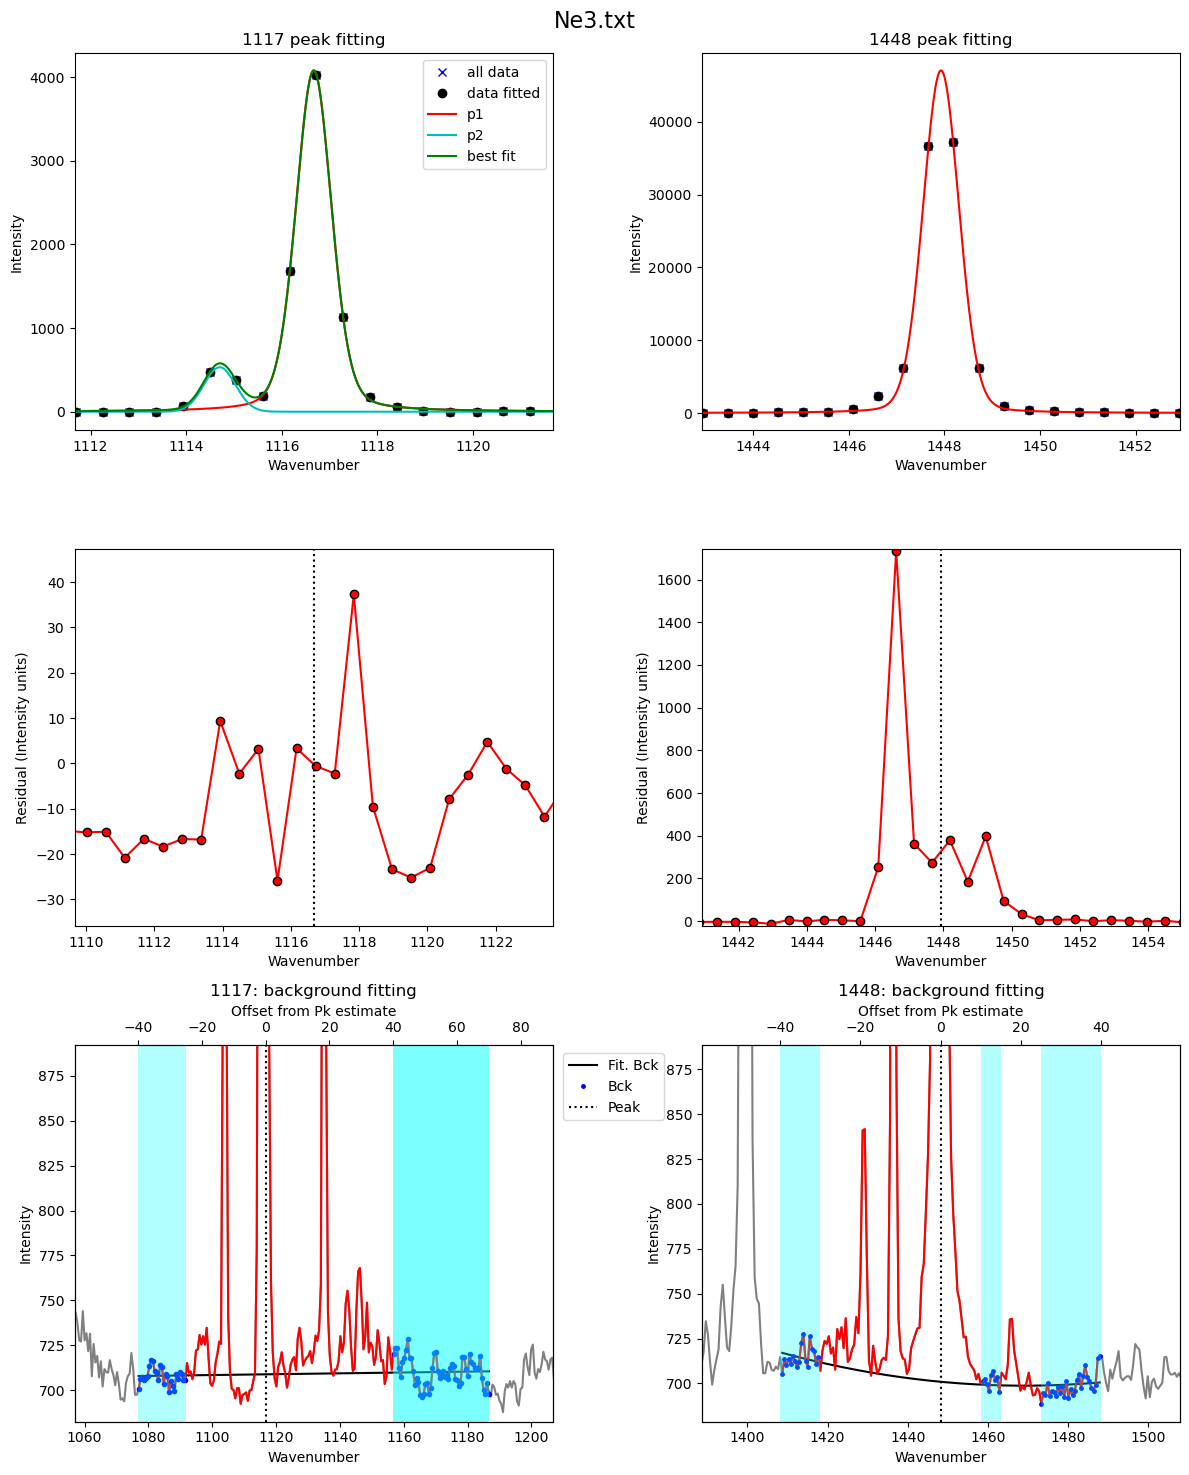

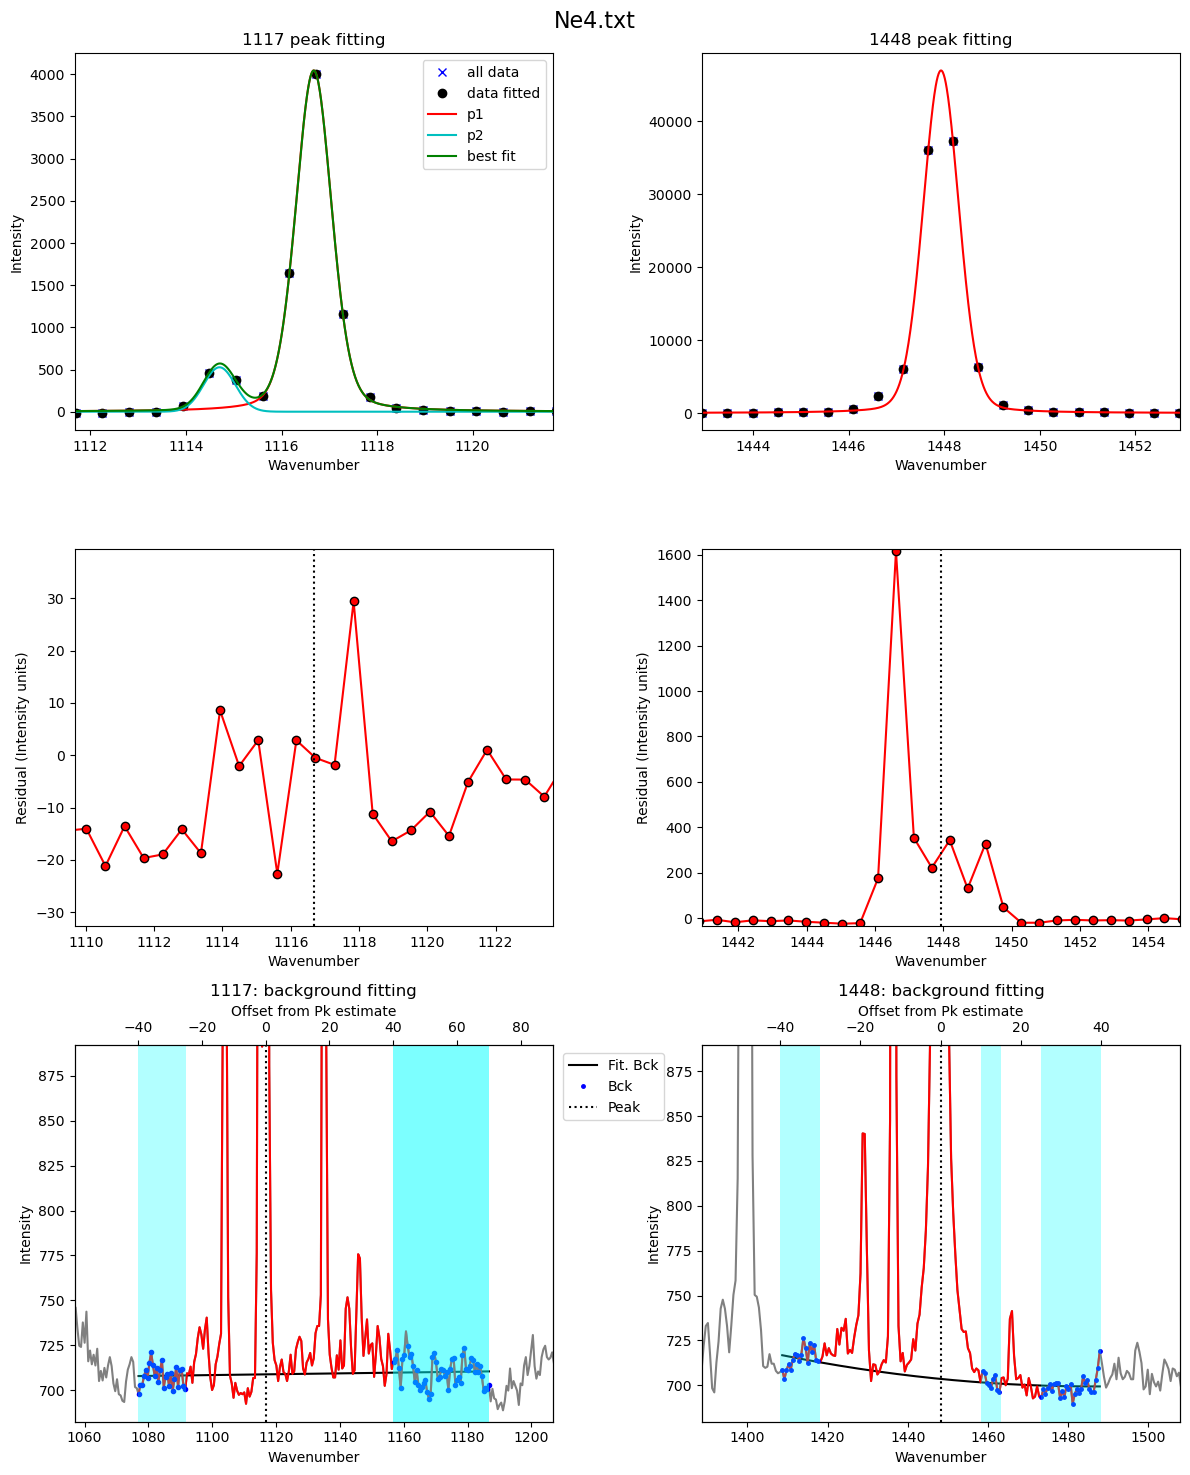

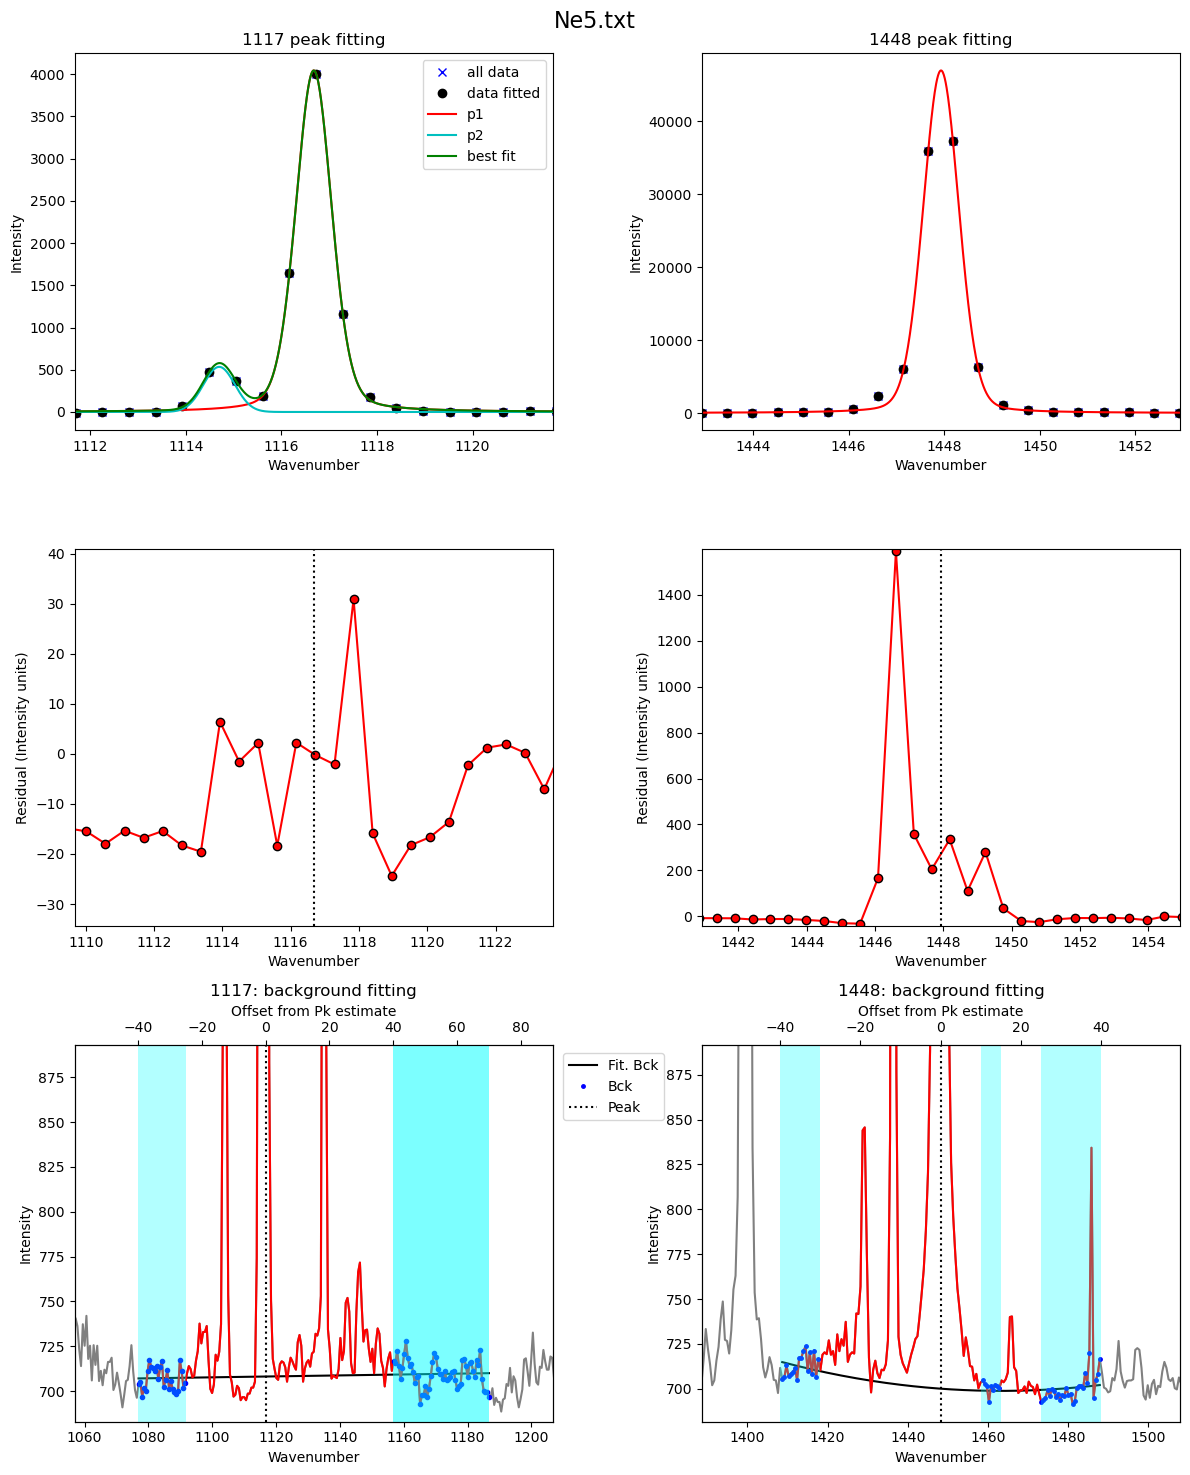

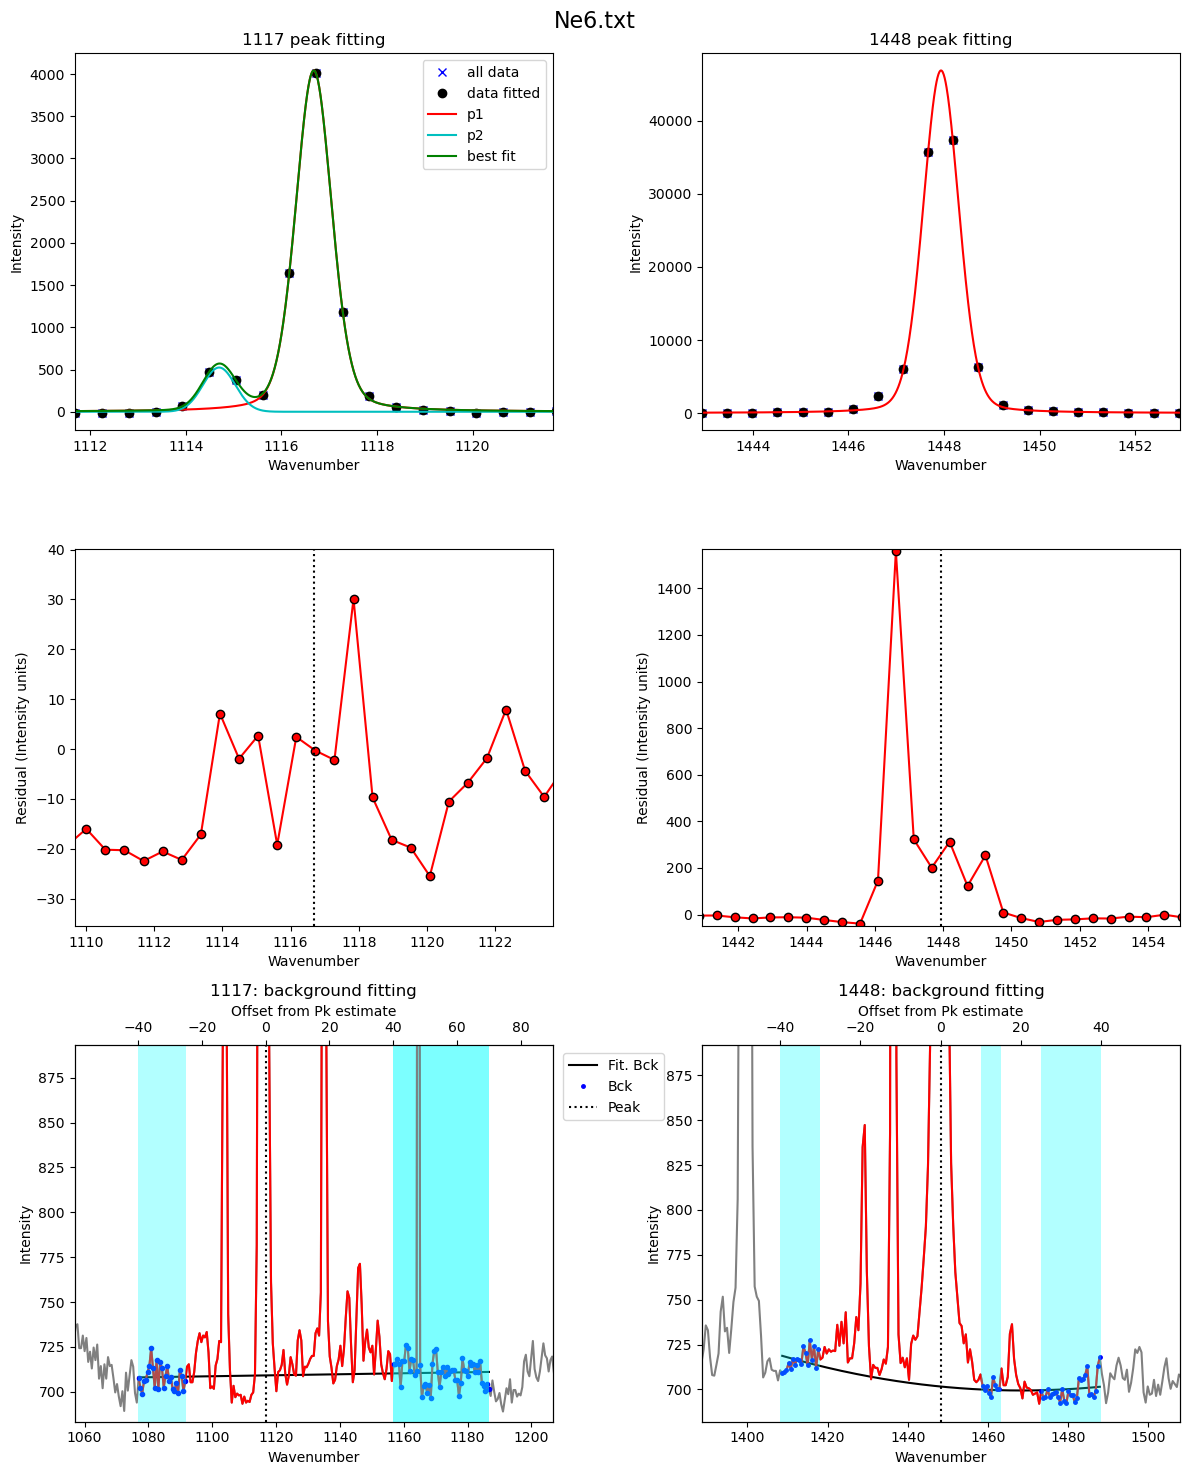

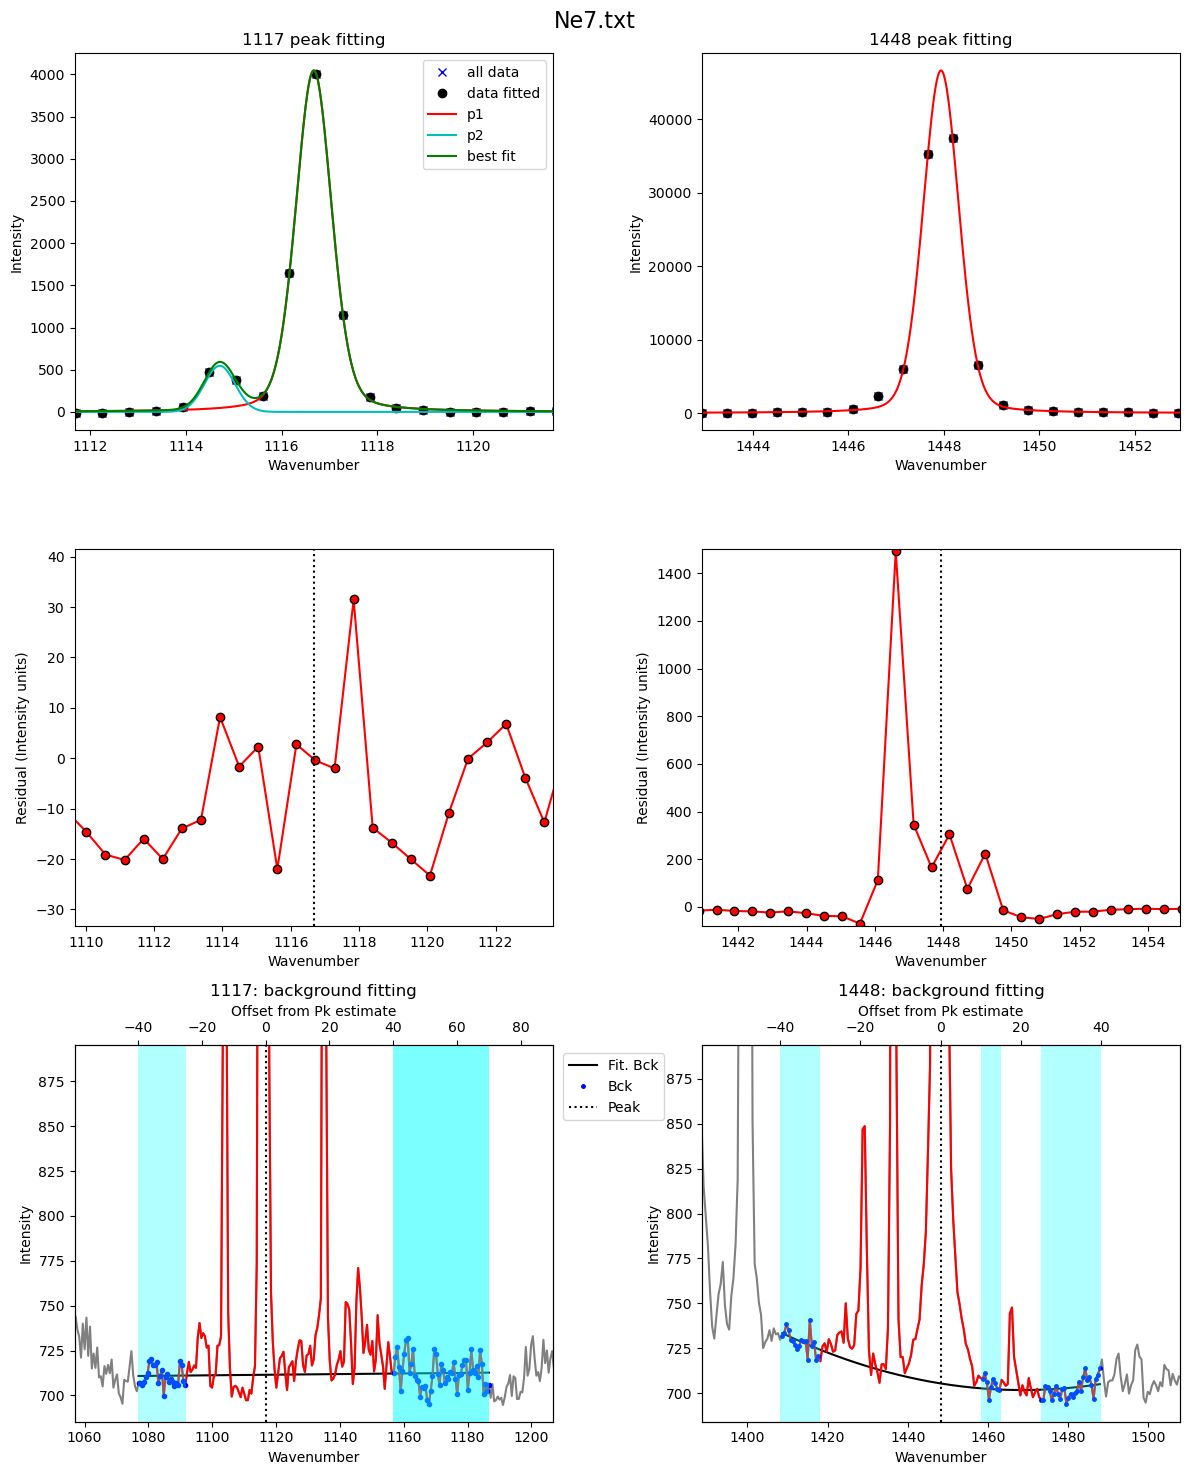

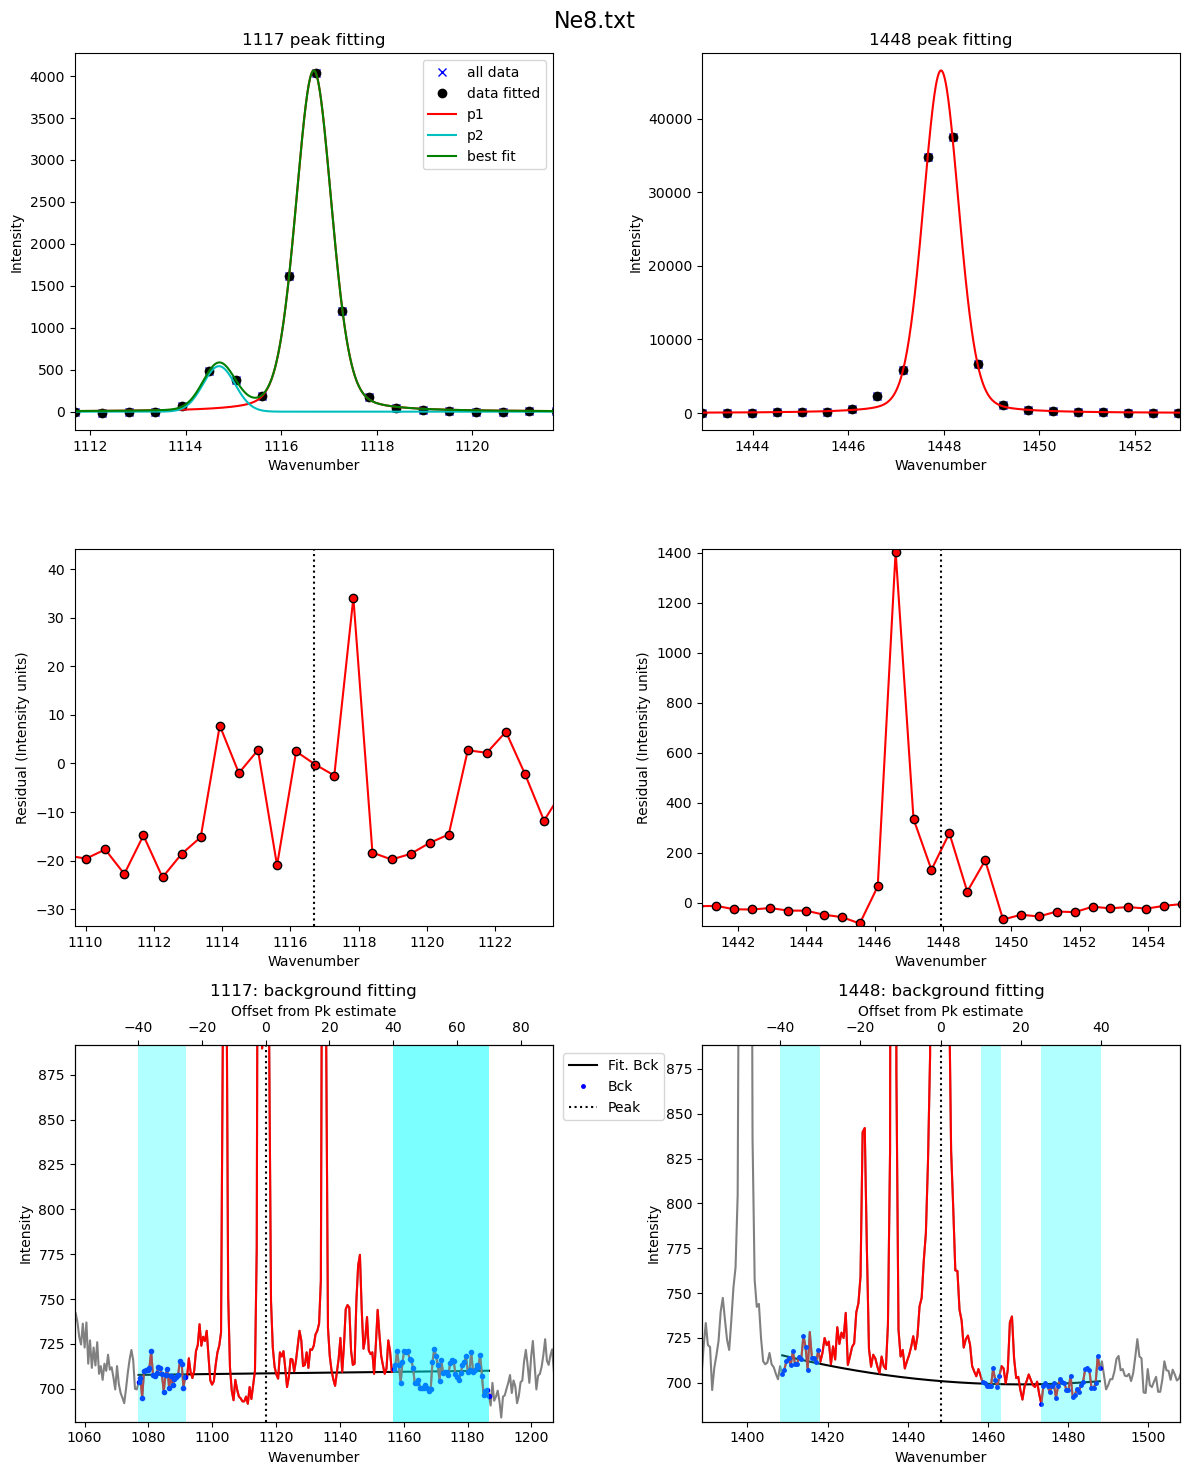

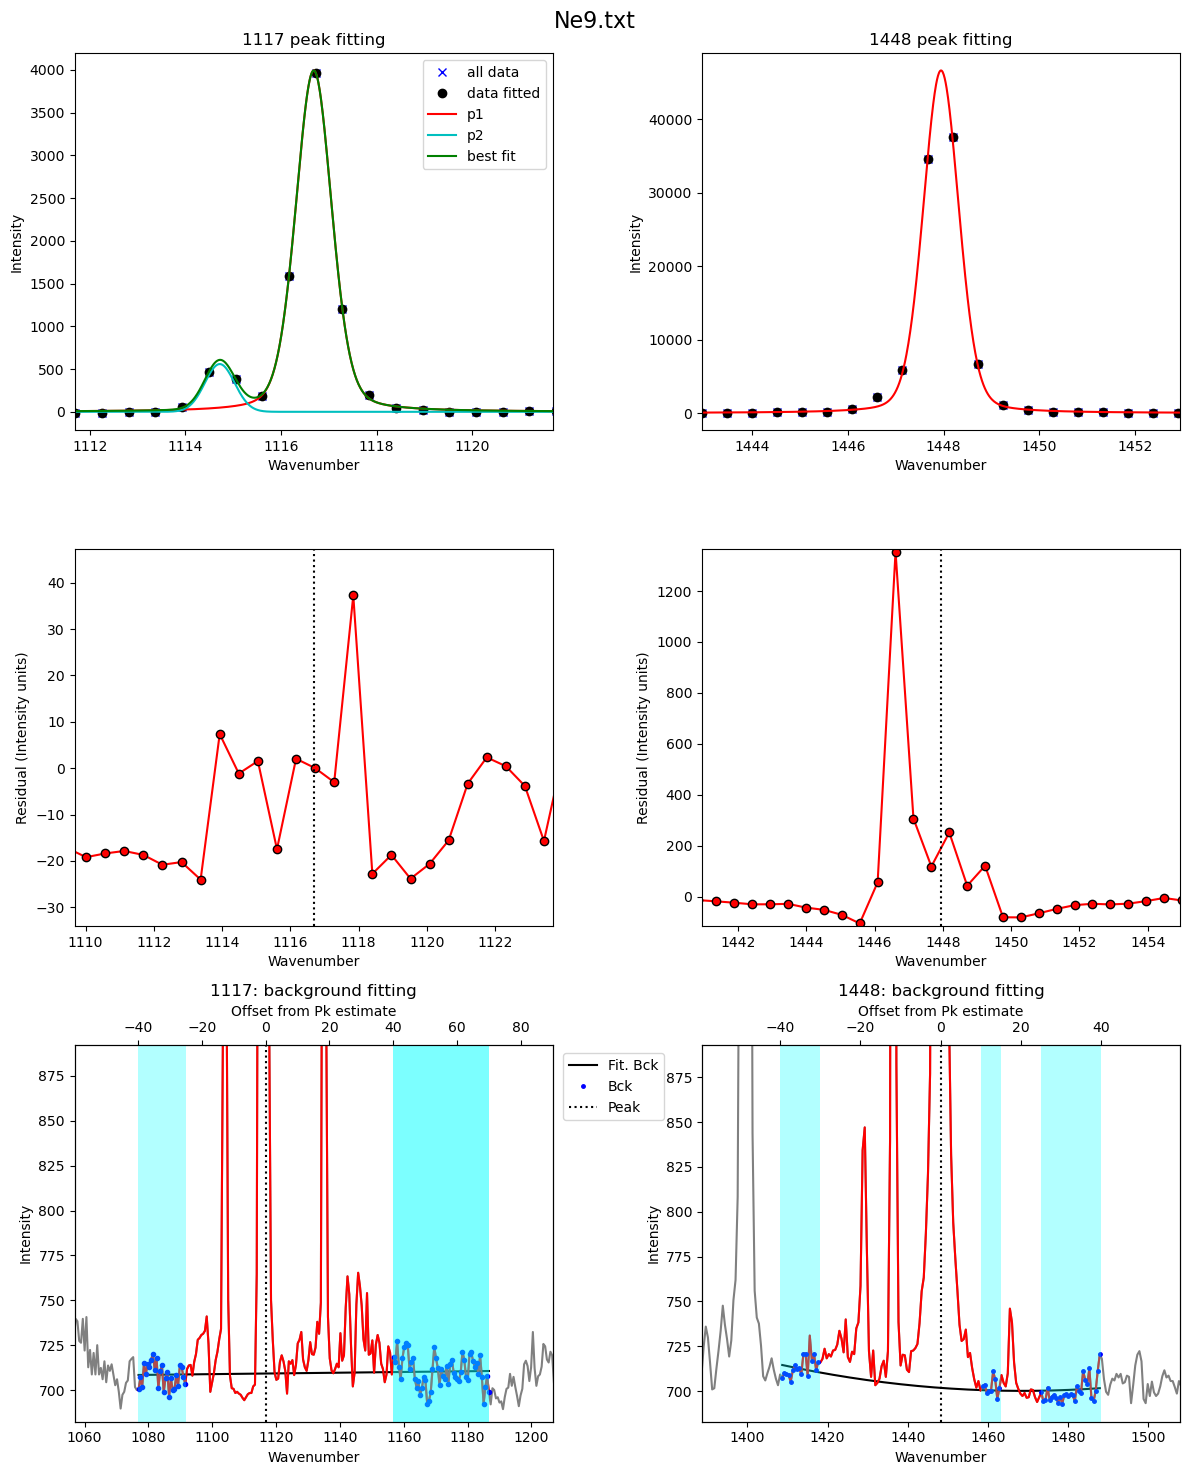

In [24]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_est,
df_fit_params=df_fit_params,  prefix=prefix,                   
plot_figure=True, const_params=True)


In [25]:
df2

filename   Ne_Corr  1σ_Ne_Corr     deltaNe  pk2_peak_cent  pk1_peak_cent  \
0    Ne1.txt  0.997662    0.000040  331.252023    1447.911816    1116.659793   
1   Ne10.txt  0.997592    0.000037  331.275277    1447.972051    1116.696773   
2   Ne11.txt  0.997594    0.000036  331.274702    1447.976910    1116.702207   
3   Ne12.txt  0.997587    0.000038  331.277024    1447.981288    1116.704264   
4   Ne13.txt  0.997574    0.000038  331.281244    1447.982511    1116.701267   
5   Ne14.txt  0.997581    0.000037  331.279023    1447.980679    1116.701656   
6   Ne15.txt  0.997573    0.000038  331.281690    1447.982715    1116.701025   
7   Ne16.txt  0.997583    0.000037  331.278189    1447.983647    1116.705458   
8   Ne17.txt  0.997570    0.000037  331.282570    1447.984591    1116.702021   
9   Ne18.txt  0.997555    0.000037  331.287759    1447.982499    1116.694741   
10  Ne19.txt  0.997560    0.000037  331.285847    1447.981330    1116.695483   
11   Ne2.txt  0.997644    0.000038  331.258046    1447.922817    1116.664771   
12  Ne20.txt  0.997540    0.000037  331.292762    1447.982273    1116.689512   
13  Ne21.txt  0.997552    0.000036  331.288649    1447.986791    1116.698142   
14  Ne22.txt  0.997538    0.000040  331.293360    1447.986985    1116.693625   
15  Ne23.txt  0.997546    0.000037  331.290754    1447.983782    1116.693028   
16  Ne24.txt  0.997539    0.000037  331.292882    1447.980219    1116.687337   
17  Ne25.txt  0.997532    0.000036  331.295316    1447.984452    1116.689136   
18  Ne26.txt  0.997536    0.000037  331.294041    1447.984055    1116.690014   
19   Ne3.txt  0.997641    0.000038  331.259028    1447.928030    1116.669002   
20   Ne4.txt  0.997643    0.000037  331.258483    1447.933242    1116.674760   
21   Ne5.txt  0.997642    0.000038  331.258733    1447.934592    1116.675859   
22   Ne6.txt  0.997642    0.000045  331.258732    1447.936203    1116.677470   
23   Ne7.txt  0.997619    0.000037  331.266246    1447.940425    1116.674179   
24   Ne8.txt  0.997634    0.000037  331.261423    1447.943653    1116.682230   
25   Ne9.txt  0.997633    0.000037  331.261636    1447.946057    1116.684421   

    pk2_amplitude  pk1_amplitude  residual_pk2  residual_pk1  ...  pk2_gamma  \
0    46987.105473    4007.696435     85.069029     12.065189  ...       None   
1    49993.446737    4203.085299    109.104890     12.034015  ...       None   
2    50312.583305    4360.890791    111.544623     12.482156  ...       None   
3    51054.637292    4273.835315    114.857667     11.536560  ...       None   
4    50345.984120    4308.274934    114.855346     12.680745  ...       None   
5    50145.780374    4268.533976    109.745341     11.619536  ...       None   
6    49699.064538    4237.380342    111.782761     11.487693  ...       None   
7    51079.698462    4276.645176    113.336869     11.313749  ...       None   
8    49650.117380    4305.645713    109.234204     12.625976  ...       None   
9    49433.603986    4270.580306    103.875798     12.755092  ...       None   
10   48402.201503    4175.877649    109.767077     12.055548  ...       None   
11   46489.708477    4199.608706     97.513782     10.887394  ...       None   
12   48683.373909    4336.485004    111.201259     13.304803  ...       None   
13   48499.897558    4317.231541    108.935425     12.081518  ...       None   
14   49856.825344    4112.309093    104.745939     13.659244  ...       None   
15   48796.694234    4287.855619    105.750713     13.076362  ...       None   
16   47343.318094    4293.222449    102.436652     12.522982  ...       None   
17   48267.387800    4295.873408    111.690575     11.601699  ...       None   
18   48723.131508    4236.559982    108.847716     13.241484  ...       None   
19   46633.573534    4261.321618     99.248232     12.346281  ...       None   
20   46816.780488    4230.019572     91.796797     10.984729  ...       None   
21   46798.468324    4234.552582     88.031646     11.002211  ...       None   
22 

## Now extract metadata to get a timestamp for each file

In [26]:
## Get meta files
Ne_files_meta=pf.get_files(path=meta_path,
file_ext='txt', ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files_meta[0:5]

['Ne1.txt', 'Ne10.txt', 'Ne11.txt', 'Ne12.txt', 'Ne13.txt']

In [27]:
# This cell stitches metadata together - e.g. gets your laser power, time stamp, accumulations etc
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=Ne_files_meta, prefix=prefix, trupower=TruPower)
meta.head()

100%|██████████| 26/26 [00:17<00:00,  1.47it/s]

Done


filename            date Month  Day  power (mW)  Int_time (s)  \
0   Ne1.txt  June 7, 2023\n  June  7.0      35.213          45.0   
11  Ne2.txt  June 7, 2023\n  June  7.0      34.583          45.0   
19  Ne3.txt  June 7, 2023\n  June  7.0      34.546          45.0   
20  Ne4.txt  June 7, 2023\n  June  7.0      34.452          45.0   
21  Ne5.txt  June 7, 2023\n  June  7.0      34.375          45.0   

    accumulations  Mag (X)             duration      24hr_time  \
0             3.0      5.0  ['0h', '2m', '17s']  11:37:08 AM\n   
11            3.0      5.0  ['0h', '2m', '16s']  11:51:08 AM\n   
19            3.0      5.0  ['0h', '2m', '16s']  11:55:42 AM\n   
20            3.0      5.0  ['0h', '2m', '16s']  12:01:18 PM\n   
21            3.0      5.0  ['0h', '2m', '16s']  12:04:44 PM\n   

    sec since midnight  Spectral Center  
0              41828.0         1325.004  
11             42668.0         1325.004  
19             42942.0         1325.004  
20             43278.0         1325.004  
21             43484.0         1325.004

In [28]:
# This is getting the metadata file names.  Check here the prefix has been removed. 
file_m=pf.extracting_filenames_generic(names=meta['filename'], 
   file_ext='.txt')
file_m

good job, no duplicate file names


array(['Ne1', 'Ne2', 'Ne3', 'Ne4', 'Ne5', 'Ne6', 'Ne7', 'Ne8', 'Ne9',
       'Ne10', 'Ne11', 'Ne12', 'Ne13', 'Ne14', 'Ne15', 'Ne16', 'Ne17',
       'Ne18', 'Ne19', 'Ne20', 'Ne21', 'Ne22', 'Ne23', 'Ne24', 'Ne25',
       'Ne26'], dtype=object)

In [29]:
# This is getting the spectra file names. Check that they are in the same format as the metadataones above, this is what you need to successfully stitch together. 
file_s=pf.extracting_filenames_generic(names=df2['filename'],
   file_ext='.txt')
file_s

good job, no duplicate file names


array(['Ne1', 'Ne10', 'Ne11', 'Ne12', 'Ne13', 'Ne14', 'Ne15', 'Ne16',
       'Ne17', 'Ne18', 'Ne19', 'Ne2', 'Ne20', 'Ne21', 'Ne22', 'Ne23',
       'Ne24', 'Ne25', 'Ne26', 'Ne3', 'Ne4', 'Ne5', 'Ne6', 'Ne7', 'Ne8',
       'Ne9'], dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [30]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [31]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

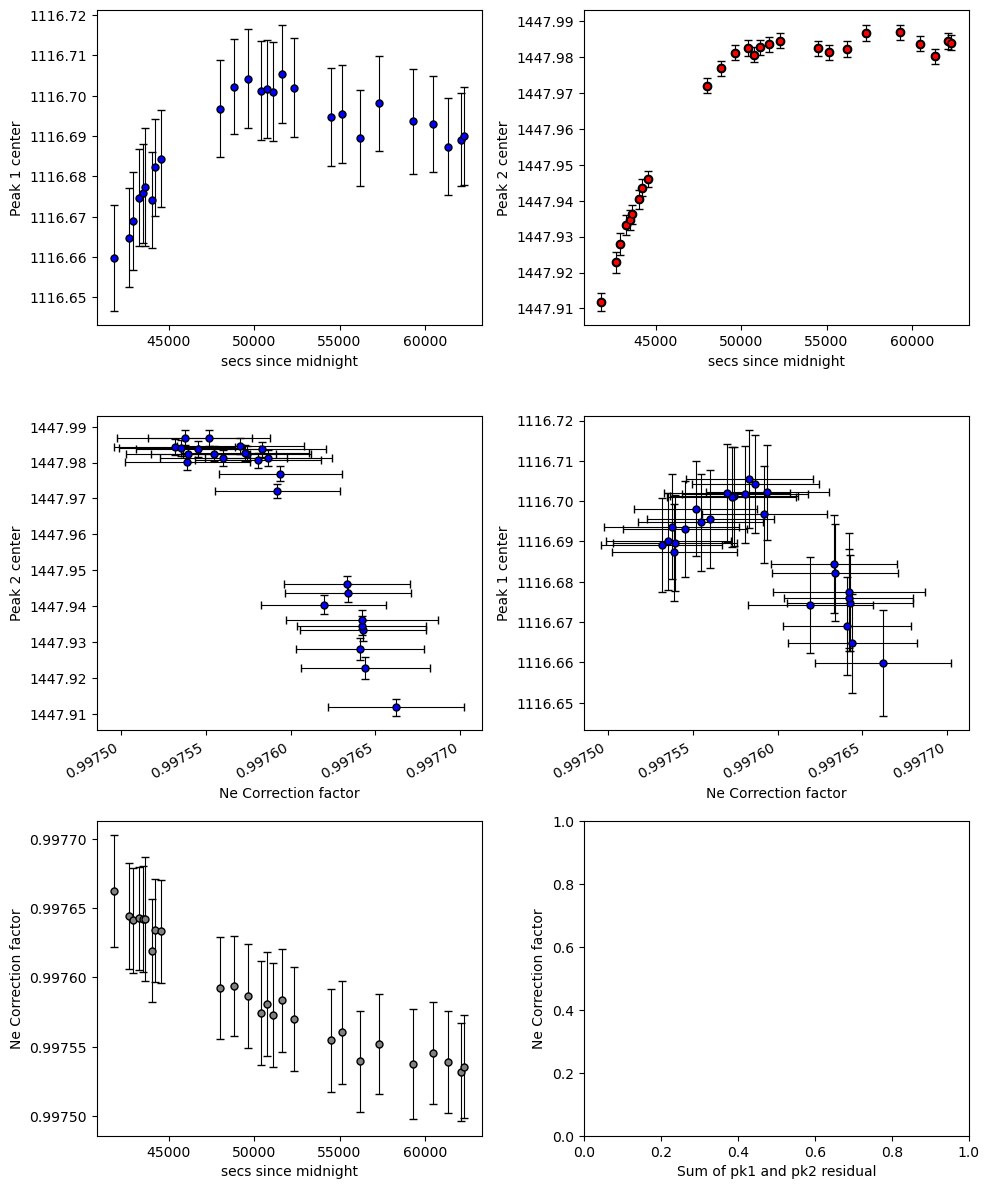

In [32]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right
- Smaller number of offset - more discarded
- If you notice really bad fits, you can also exclude certain files like file_name_filt=['Ne_line_1.txt'], or file_name_filt=['Ne_line_2.txt', 'Ne_line_5.txt']

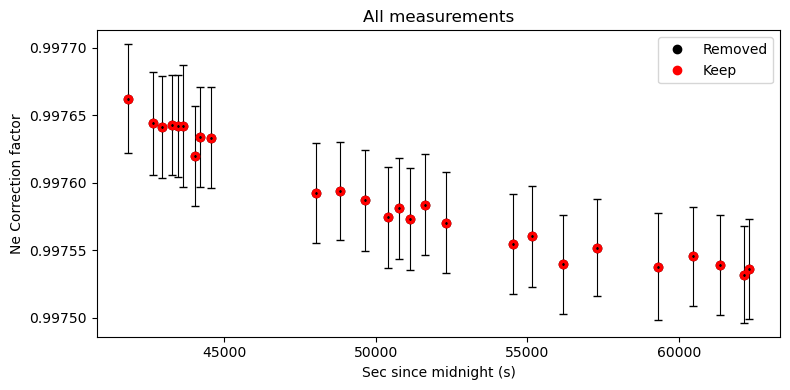

In [33]:
filt=pf.filter_Ne_Line_neighbours(df_combo=df_combo, 
                    number_av=3, offset=0.001, file_name_filt=None)
# Now lets plot this to see
fig, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.errorbar(df_combo['sec since midnight'], df_combo['Ne_Corr'], xerr=0, 
yerr=df_combo['1σ_Ne_Corr'], fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=1, mec='k', capsize=3)
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='Removed')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Keep')

ax1.legend()

ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')

fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

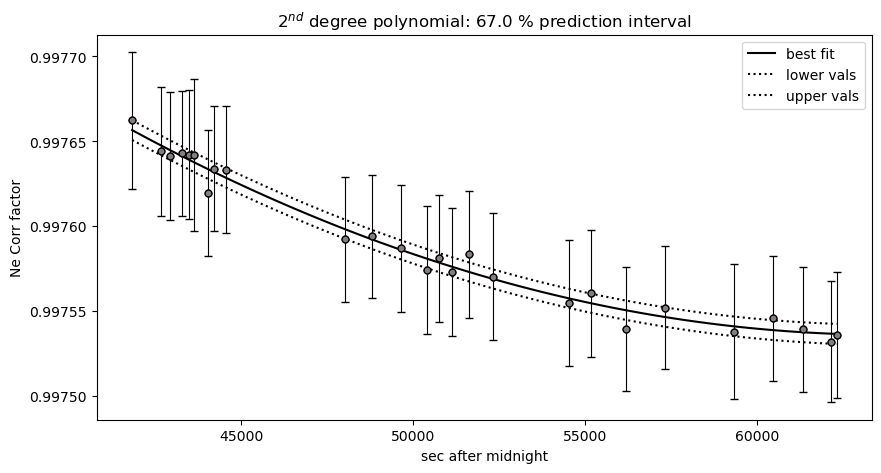

In [34]:

big_err=df_combo['1σ_Ne_Corr']>0.0001
## Lets get filtered ones
keep=(filt>0)&(~big_err)

pf.generate_Ne_corr_model(time=df_combo['sec since midnight'].loc[keep], Ne_corr=df_combo.loc[keep], 
N_poly=2, CI=0.67, pkl_name='Neon_corr_model_1117_1147.pkl')
